# Personalization Process


## Importing libraries

In [30]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from __future__ import print_function

from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import silhouette_samples, silhouette_score
print(__doc__)
range_n_clusters = [2, 3, 4, 5, 6]

# we are using the scipy implementation
from scipy.spatial.distance import cdist, pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, inconsistent

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
%matplotlib inline

Automatically created module for IPython interactive environment


In [31]:
# define the color palettes
data_colors = ['#a6cdf6','#b2d0b7','#f98ea1', '#ffc0cb', '#800080', '#FFFF00']
background_cmap3 = ListedColormap(['#a6cdf6','#b2d0b7','#f98ea1'])
centroid_colors = ['#1b80e8','#599062','#e20c32','#FF1493', '#800080', '#FFD700' ]
centroid_cmap = ListedColormap(centroid_colors)

## Importing data 

In [32]:
# df = pd.read_csv('/content/sample_data/dataset_project_eHealth20232024.csv')
df = pd.read_csv('../data/dataset_project_eHealth20232024.csv')
random_state = 10
print("datashape: ", df.shape)
print(df.info())
n_samples = df.shape[0]

datashape:  (160, 54)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 54 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        159 non-null    float64
 1   gender     160 non-null    int64  
 2   education  159 non-null    float64
 3   marital    160 non-null    int64  
 4   income     160 non-null    int64  
 5   phq_1      160 non-null    int64  
 6   phq_2      155 non-null    float64
 7   phq_3      159 non-null    float64
 8   phq_4      160 non-null    int64  
 9   phq_5      160 non-null    int64  
 10  phq_6      160 non-null    int64  
 11  phq_7      159 non-null    float64
 12  phq_8      159 non-null    float64
 13  phq_9      159 non-null    float64
 14  gad_1      159 non-null    float64
 15  gad_2      160 non-null    int64  
 16  gad_3      159 non-null    float64
 17  gad_4      159 non-null    float64
 18  gad_5      159 non-null    float64
 19  gad_6      159 non-null    f

## Missing Data & column selection

In [33]:
# Sex and marital status -> average
# df_ccs['age'].fillna(df_ccs.mean()['age'])
# df_ccs['education'].fillna(df_ccs.median()['education'])
df['age'] = df['age'].fillna(df['age'].mean())
df['education'] = df['education'].fillna(df['education'].mean())

columns_to_drop = df.columns[3:29] # Columns 5 to 41
columns_to_drop = columns_to_drop.insert(0, df.columns[1])
# columns_to_drop = columns_to_drop.append(df.columns[1])
# columns_to_drop = df.columns[0:42] # Columns 0 to 41
print(columns_to_drop)
df_ccs = df.drop(columns=columns_to_drop)
# df_ccs = df_ccs.dropna()
# print(df.head())
with pd.option_context('display.max_rows', 10,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(df_ccs)


Index(['gender', 'marital', 'income', 'phq_1', 'phq_2', 'phq_3', 'phq_4',
       'phq_5', 'phq_6', 'phq_7', 'phq_8', 'phq_9', 'gad_1', 'gad_2', 'gad_3',
       'gad_4', 'gad_5', 'gad_6', 'gad_7', 'eheals_1', 'eheals_2', 'eheals_3',
       'eheals_4', 'eheals_5', 'eheals_6', 'eheals_7', 'eheals_8'],
      dtype='object')
      age  education  heas_1  heas_2  heas_3  heas_4  heas_5  heas_6  heas_7  \
0    42.0        5.0     1.0     0.0     0.0       0       0       0       2   
1    51.0       18.0     0.0     1.0     2.0       0       0       2       0   
2    40.0        8.0     0.0     2.0     0.0       0       0       0       0   
3    19.0       25.0     0.0     0.0     3.0       3       3       3       3   
4    42.0       13.0     1.0     0.0     1.0       2       0       0       3   
..    ...        ...     ...     ...     ...     ...     ...     ...     ...   
155  29.0       18.0     3.0     3.0     3.0       2       2       3       3   
156  40.0       13.0     1.0     0.0  

## Features creation

In [34]:
def reverse_score(string):
    # print(df_ccs[string])
    df_ccs[string] = df_ccs[string] - 3
    df_ccs[string] = - df_ccs[string]
    df_ccs[string] = df_ccs[string] + 3
    # print(df_ccs[string])

In [35]:
to_be_reversed = ['ccs_3', 'ccs_6', 'ccs_7', 'ccs_12', 'heas_1', 'heas_2', 'heas_3', 'heas_4', 'heas_5', 'heas_6', 'heas_7',
       'heas_8', 'heas_9', 'heas_10', 'heas_11', 'heas_12', 'heas_13']

for feature in to_be_reversed:
    reverse_score(feature)

data_ccs = pd.DataFrame() 
data_ccs['Age'] = df_ccs['age']
data_ccs['Education'] = df_ccs['education']
# data_ccs['Education'] = df_ccs['education']
data_ccs['Affective Symptoms'] = df_ccs[['heas_1', 'heas_2', 'heas_3', 'heas_4']].mean(axis=1)
data_ccs['Rumination'] = df_ccs[['heas_5', 'heas_6', 'heas_7']].mean(axis=1)
data_ccs['Behavioural Symptoms'] = df_ccs[['heas_8', 'heas_9', 'heas_10']].mean(axis=1)
data_ccs['Anxiety Personal Impact'] = df_ccs[['heas_11', 'heas_12', 'heas_13']].mean(axis=1)
data_ccs['Attribution Skepticism'] = df_ccs[['ccs_2', 'ccs_6', 'ccs_9']].mean(axis=1)
data_ccs['Impact Skepticism'] = df_ccs[['ccs_3', 'ccs_5', 'ccs_12']].mean(axis=1)
data_ccs['Trend Skepticism'] = df_ccs[['ccs_1', 'ccs_7', 'ccs_11']].mean(axis=1)
data_ccs['Response Skepticism'] = df_ccs[['ccs_4', 'ccs_8', 'ccs_10']].mean(axis=1)

print (data_ccs.info())

final_df = data_ccs
final_df['Gender'] = df['gender']
final_df['Marital'] = df['marital']
final_df['Education'] = df['education']
final_df['Income'] = df['income']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      160 non-null    float64
 1   Education                160 non-null    float64
 2   Affective Symptoms       160 non-null    float64
 3   Rumination               160 non-null    float64
 4   Behavioural Symptoms     160 non-null    float64
 5   Anxiety Personal Impact  160 non-null    float64
 6   Attribution Skepticism   160 non-null    float64
 7   Impact Skepticism        160 non-null    float64
 8   Trend Skepticism         160 non-null    float64
 9   Response Skepticism      160 non-null    float64
dtypes: float64(10)
memory usage: 12.6 KB
None


In [36]:
# You create a MinMaxScaler object called min_max_scaler. This object will be used to perform the min-max scaling.
# You apply the fit_transform method of the MinMaxScaler to scale the data in the DataFrame df and store the scaled data in np_df.

# EXTRA: The inverse_transform method is used to revert the scaling
# transformation performed by the MinMaxScaler back to the original scale.
# In your code, you are trying to reverse the scaling and obtain the original data.


min_max_scaler = preprocessing.MinMaxScaler()
normalized_data = min_max_scaler.fit_transform(data_ccs)
X_nrm = pd.DataFrame(normalized_data, columns=data_ccs.columns)
# print(X_nrm)

std_scaler = StandardScaler()
standardized_data = std_scaler.fit_transform(data_ccs)
X_std = pd.DataFrame(standardized_data, columns=data_ccs.columns)
# print(X_std)


## K-Means

#### Normalized Data

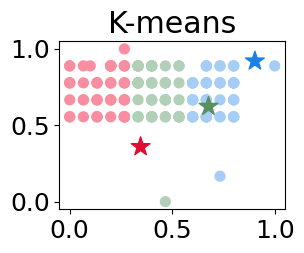

In [37]:
model_nrm = KMeans(n_clusters=3, n_init='auto').fit(X_nrm)
y_pred_nrm = model_nrm.predict(X_nrm)
plt.subplot(221)
plt.scatter(X_nrm['Trend Skepticism'], X_nrm['Response Skepticism'], s=50, c=[data_colors[y] for y in y_pred_nrm])
plt.scatter(model_nrm.cluster_centers_[:,3], model_nrm.cluster_centers_[:,4], marker='*', s=200, c=centroid_colors[:len(model_nrm.cluster_centers_)])
plt.title("K-means")
    
# print(y_pred_nrm)
final_df['Cluster'] = y_pred_nrm
final_df.to_csv('Nrm_kmeans3_df.csv')
# final_df.to_csv('Nrm_kmeans6_df.csv')

#### Standardized Data

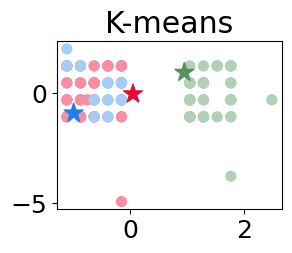

In [38]:
model_std = KMeans(n_clusters=3, n_init='auto').fit(X_std)
y_pred_std = model_std.predict(X_std)
plt.subplot(221)
plt.scatter(X_std['Impact Skepticism'], X_std['Response Skepticism'], s=50, c=[data_colors[y] for y in y_pred_std])
plt.scatter(model_std.cluster_centers_[:,2], model_std.cluster_centers_[:,4], marker='*', s=200, c=centroid_colors[:len(model_std.cluster_centers_)])
plt.title("K-means")


# print(y_pred_nrm)
final_df['Cluster'] = y_pred_nrm
final_df.to_csv('Std_kmeans3_df.csv')
# final_df.to_csv('Std_kmeans6_df.csv')

#### Knee-elbow analysis

In [39]:
def KneeElbowAnalysis(x,max_k=20):
    k_values = range(2,max_k)
    clusterings = [KMeans(n_clusters=k, random_state=random_state, n_init='auto').fit(x) for k in k_values]
    centroids = [clustering.cluster_centers_ for clustering in clusterings]

    D_k = [cdist(x, cent, 'euclidean') for cent in centroids]
    cIdx = [np.argmin(D,axis=1) for D in D_k]
    dist = [np.min(D,axis=1) for D in D_k]
    avgWithinSS = [sum(d)/x.shape[0] for d in dist]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]

    tss = sum(pdist(x)**2)/x.shape[0]
    bss = tss-wcss

    kIdx = 10-1
    
    #
    # elbow curve
    #
    fig = plt.figure()
    font = {'family' : 'sans', 'size'   : 12}
    plt.rc('font', **font)
    plt.xticks(k_values)
    plt.plot(k_values, wcss, 'o-', color='red', label='WCSS')
    plt.plot(k_values, bss, 'o-', color='blue', label='BCSS')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.legend()
    plt.title('KMeans Clustering');

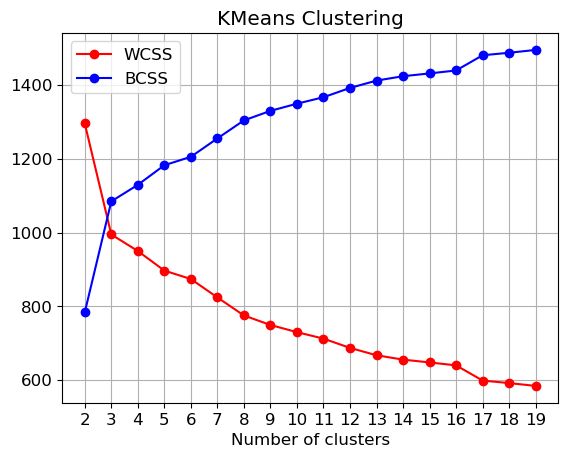

In [40]:
KneeElbowAnalysis(X_std)

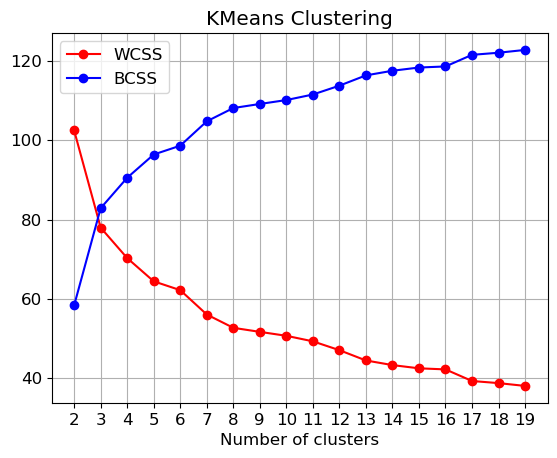

In [41]:
KneeElbowAnalysis(X_nrm)

## DBScan

#### Standardized Data

(147,)


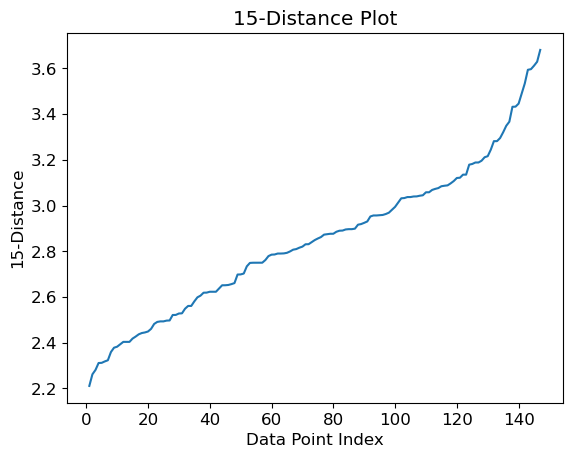

In [42]:
from sklearn.neighbors import NearestNeighbors

min_samples = 15
# Calculate pairwise distances
distances = NearestNeighbors(n_neighbors=min_samples).fit(X_std).kneighbors(X_std)[0]

# Sort distances
distances = np.sort(distances[:, min_samples - 1])

distances = distances[0:147]
print(distances.shape)

# Plot k-distance graph
plt.plot(range(1, len(distances) + 1), distances)
plt.xlabel("Data Point Index")
plt.ylabel(f"{min_samples}-Distance")
plt.title(f"{min_samples}-Distance Plot")

# Identify the knee point (elbow)
# You can do this visually or use more sophisticated methods to detect the elbow programmatically
plt.show()


In [45]:
db = DBSCAN(eps=0.47, min_samples=10).fit(X_std.values)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
print(labels)

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
noisy_points = db.labels_==-1
cluster_points = ~noisy_points

print("Number of clusters = %d"%n_clusters_)
print("Number of cluster points = %d"%sum(cluster_points))
print("Number of noisy points = %d"%sum(noisy_points))

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Number of clusters = 0
Number of cluster points = 0
Number of noisy points = 160


#### Normalized Data

(147,)


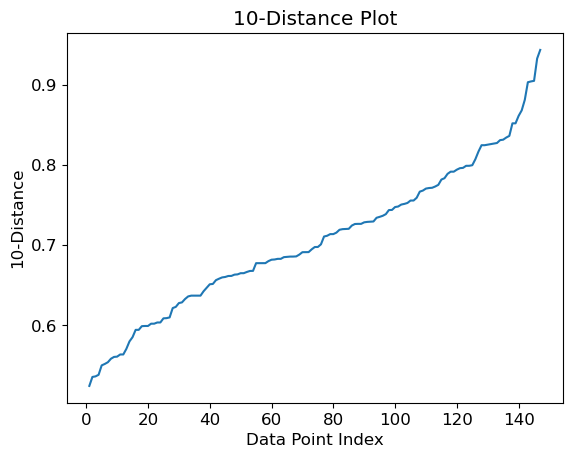

In [15]:
from sklearn.neighbors import NearestNeighbors

min_samples = 10
# Calculate pairwise distances
distances = NearestNeighbors(n_neighbors=min_samples).fit(X_nrm).kneighbors(X_nrm)[0]

# Sort distances
distances = np.sort(distances[:, min_samples - 1])

distances = distances[0:147]
print(distances.shape)

# Plot k-distance graph
plt.plot(range(1, len(distances) + 1), distances)
plt.xlabel("Data Point Index")
plt.ylabel(f"{min_samples}-Distance")
plt.title(f"{min_samples}-Distance Plot")

# Identify the knee point (elbow)
# You can do this visually or use more sophisticated methods to detect the elbow programmatically
plt.show()


In [16]:
db = DBSCAN(eps=0.42, min_samples=10).fit(X_nrm.values)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
print(labels)

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
noisy_points = db.labels_==-1
cluster_points = ~noisy_points

print("Number of clusters = %d"%n_clusters_)
print("Number of cluster points = %d"%sum(cluster_points))
print("Number of noisy points = %d"%sum(noisy_points))

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Number of clusters = 0
Number of cluster points = 0
Number of noisy points = 160


## Hierarchical Clustering

In [46]:
def plot_dendrogram():
    plt.figure(figsize=(25, 10))
    font = {'family' : 'sans', 'size'   : 18}
    plt.rc('font', **font)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    dendrogram(Z, 
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8.,  # font size for the x axis labels
    ) 
    plt.show()
    """
    dendrogram(
        Z,
        truncate_mode='lastp',  # show only the last p merged clusters
        p=25,  # show only the last p merged clusters
        show_leaf_counts=True,  # otherwise numbers in brackets are counts
        leaf_rotation=90.,
        leaf_font_size=12.,
        show_contracted=False,  # to get a distribution impression in truncated branches
    )
    """
  

In [47]:
def get_inconsistency(d):
    print("\nInconsistency analysis for d = ", d)
    inconsistency = inconsistent(Z, d)
    for i in reversed(range(1,20)):
        print("from %d to %d => Inconsistency %.3f"%(i,i+1,inconsistency[-i][3]))

#### Normalized Data

Z has 159 rows


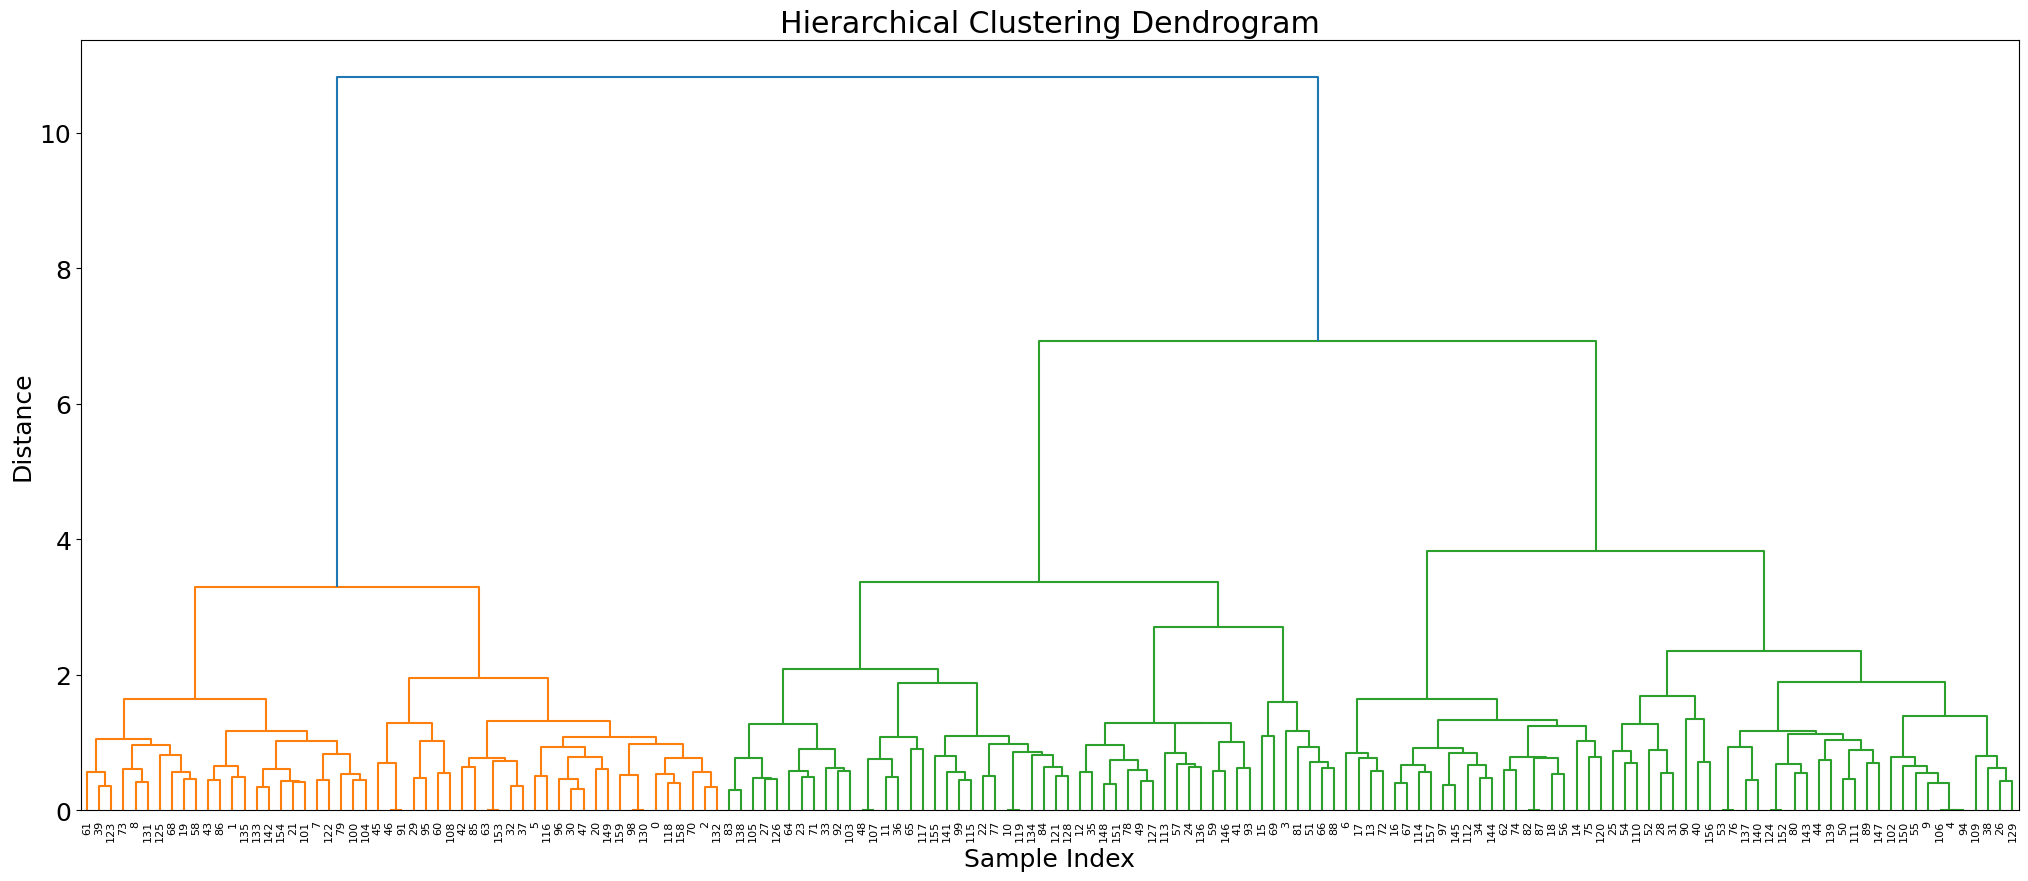


Inconsistency analysis for d =  10
from 19 to 20 => Inconsistency 2.212
from 18 to 19 => Inconsistency 1.932
from 17 to 18 => Inconsistency 0.707
from 16 to 17 => Inconsistency 2.040
from 15 to 16 => Inconsistency 1.645
from 14 to 15 => Inconsistency 3.048
from 13 to 14 => Inconsistency 2.498
from 12 to 13 => Inconsistency 1.738
from 11 to 12 => Inconsistency 2.636
from 10 to 11 => Inconsistency 2.647
from 9 to 10 => Inconsistency 3.031
from 8 to 9 => Inconsistency 2.937
from 7 to 8 => Inconsistency 2.921
from 6 to 7 => Inconsistency 3.454
from 5 to 6 => Inconsistency 4.934
from 4 to 5 => Inconsistency 4.154
from 3 to 4 => Inconsistency 4.822
from 2 to 3 => Inconsistency 7.120
from 1 to 2 => Inconsistency 9.006

Inconsistency analysis for d =  20
from 19 to 20 => Inconsistency 2.212
from 18 to 19 => Inconsistency 1.932
from 17 to 18 => Inconsistency 0.707
from 16 to 17 => Inconsistency 2.040
from 15 to 16 => Inconsistency 1.645
from 14 to 15 => Inconsistency 3.048
from 13 to 14 => Inc

In [48]:
Z = linkage(X_nrm, 'ward')
print('Z has %d rows'%(len(Z)))
plot_dendrogram()
get_inconsistency(10)
get_inconsistency(20)
n_clusters = 7
cluster_labels = []
silhouette_avg = []
for i in range(2, n_clusters):
    cluster_labels.append(fcluster(Z, i, criterion='maxclust'))
    labels, counts = np.unique(cluster_labels[i-2], return_counts=True)
    silhouette_avg.append(silhouette_score(X_nrm, cluster_labels[i-2]))
    print(labels, counts, silhouette_avg[i-2])
    

Normalized_final_df = data_ccs
# print(cluster_labels[2])
Normalized_final_df['Cluster'] = cluster_labels[1]
Normalized_final_df.to_csv('Normalized_final_df_3clusters.csv')
Normalized_final_df['Cluster'] = cluster_labels[2]
Normalized_final_df.to_csv('Normalized_final_df_4clusters.csv')

#### Standardized Data

Z has 159 rows


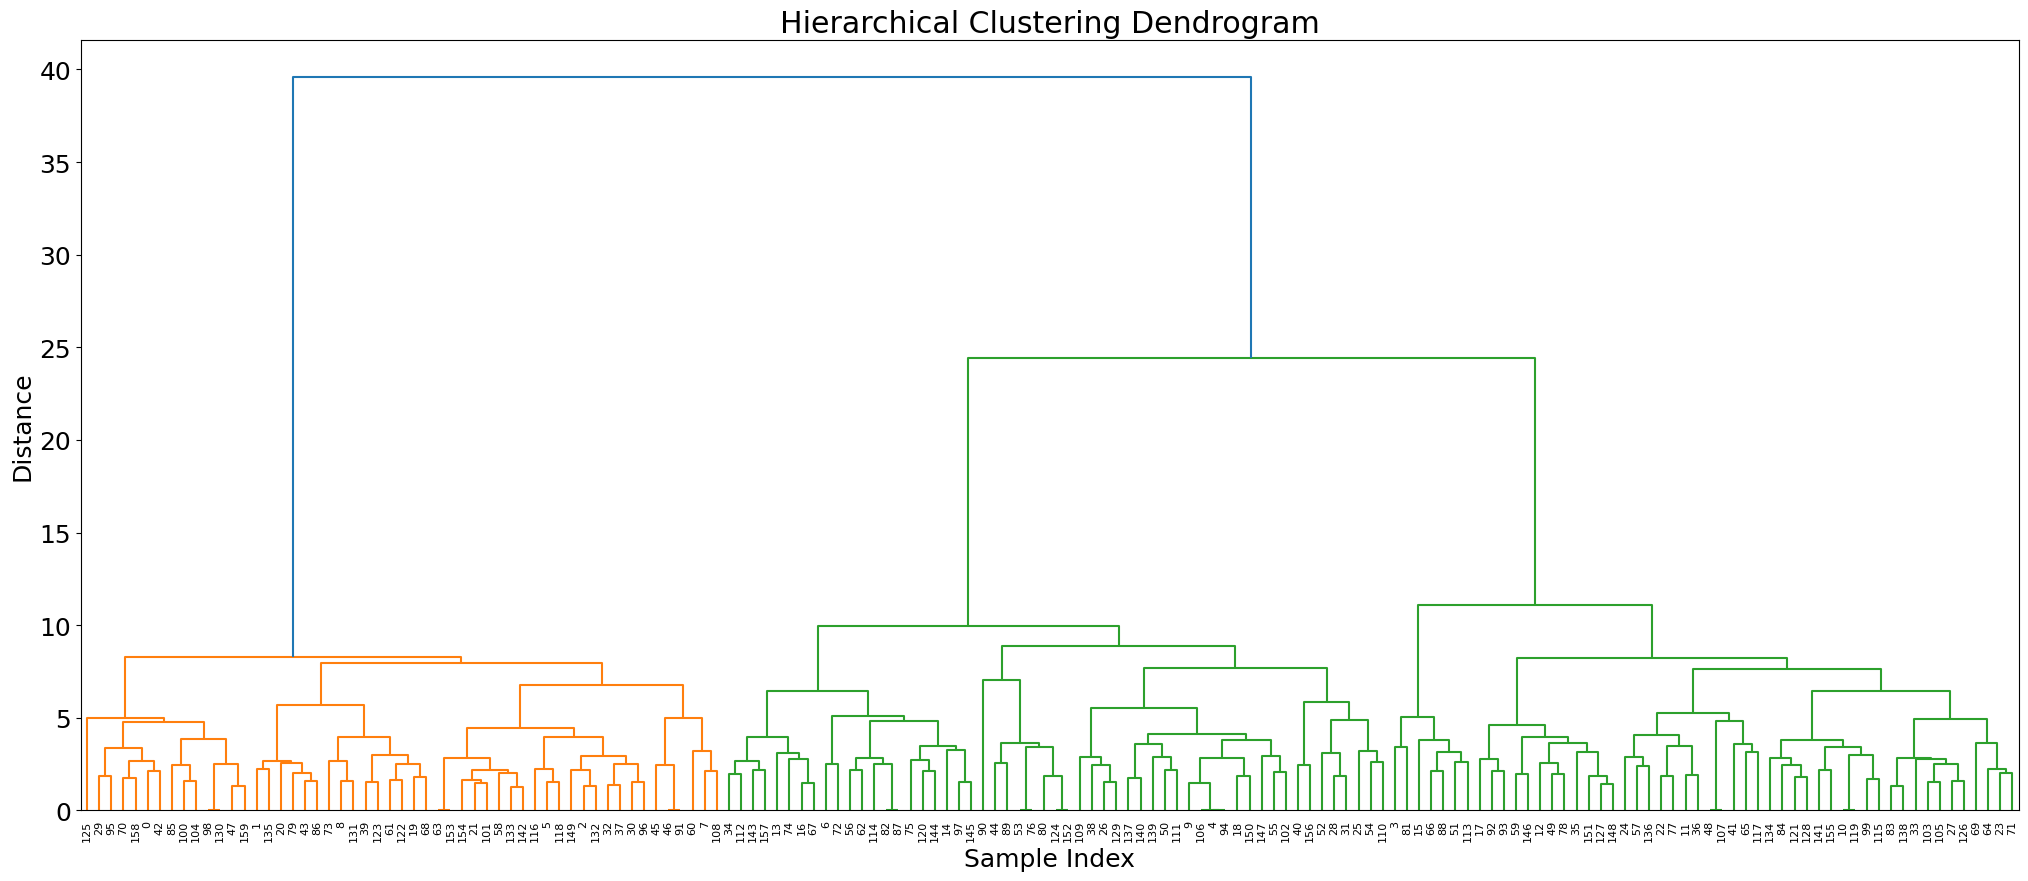


Inconsistency analysis for d =  3
from 19 to 20 => Inconsistency 1.172
from 18 to 19 => Inconsistency 1.061
from 17 to 18 => Inconsistency 1.665
from 16 to 17 => Inconsistency 2.025
from 15 to 16 => Inconsistency 1.388
from 14 to 15 => Inconsistency 1.899
from 13 to 14 => Inconsistency 1.629
from 12 to 13 => Inconsistency 1.810
from 11 to 12 => Inconsistency 1.457
from 10 to 11 => Inconsistency 1.754
from 9 to 10 => Inconsistency 1.607
from 8 to 9 => Inconsistency 1.544
from 7 to 8 => Inconsistency 1.347
from 6 to 7 => Inconsistency 1.249
from 5 to 6 => Inconsistency 1.330
from 4 to 5 => Inconsistency 1.427
from 3 to 4 => Inconsistency 1.714
from 2 to 3 => Inconsistency 2.151
from 1 to 2 => Inconsistency 1.962

Inconsistency analysis for d =  10
from 19 to 20 => Inconsistency 1.726
from 18 to 19 => Inconsistency 1.506
from 17 to 18 => Inconsistency 2.201
from 16 to 17 => Inconsistency 2.786
from 15 to 16 => Inconsistency 1.709
from 14 to 15 => Inconsistency 2.747
from 13 to 14 => Inco

In [50]:
Z = linkage(X_std, 'ward')
print('Z has %d rows'%(len(Z)))
plot_dendrogram()
get_inconsistency(3)
get_inconsistency(10)
n_clusters = 7
cluster_labels = []
silhouette_avg = []
for i in range(2, n_clusters):
    cluster_labels.append(fcluster(Z, i, criterion='maxclust'))
    #print(cluster_labels)
    labels, counts = np.unique(cluster_labels[i-2], return_counts=True)
    silhouette_avg.append(silhouette_score(X_std, cluster_labels[i-2]))
    print(labels, counts, silhouette_avg[i-2])
    
Std_final_df = data_ccs
# print(cluster_labels[2])
Std_final_df['Cluster'] = cluster_labels[1]
Std_final_df.to_csv('Std_final_df_3clusters.csv')
Std_final_df['Cluster'] = cluster_labels[2]
Std_final_df.to_csv('Std_final_df_4clusters.csv')


# Silhouette visualization

### Kmeans silhouette

For n_clusters = 2 The average silhouette_score is : 0.32814067833781674
For n_clusters = 3 The average silhouette_score is : 0.28153890055555875


/Users/caterinagiardi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/caterinagiardi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/caterinagiardi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 4 The average silhouette_score is : 0.26316349364999886
For n_clusters = 5 The average silhouette_score is : 0.21182284447697794
For n_clusters = 6 The average silhouette_score is : 0.14274832994124453
For n_clusters = 7 The average silhouette_score is : 0.19886254147971819


/Users/caterinagiardi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/caterinagiardi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/caterinagiardi/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


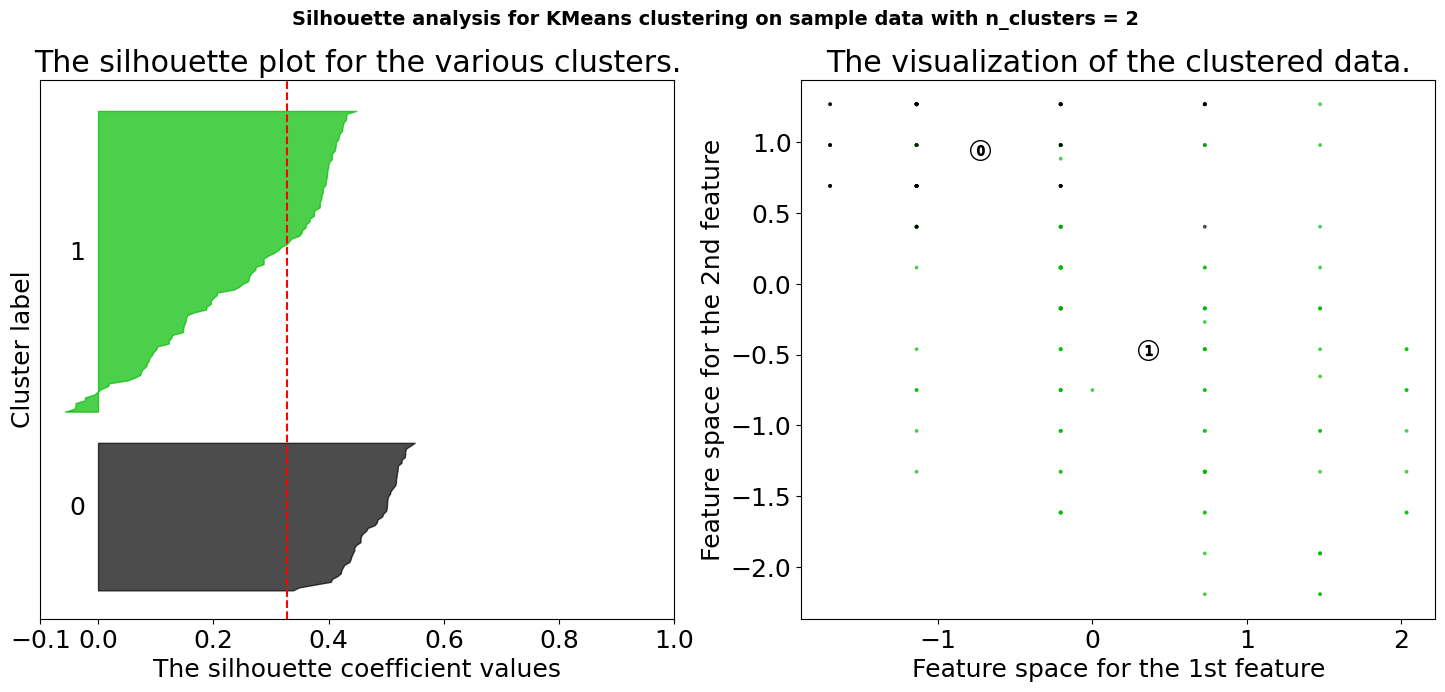

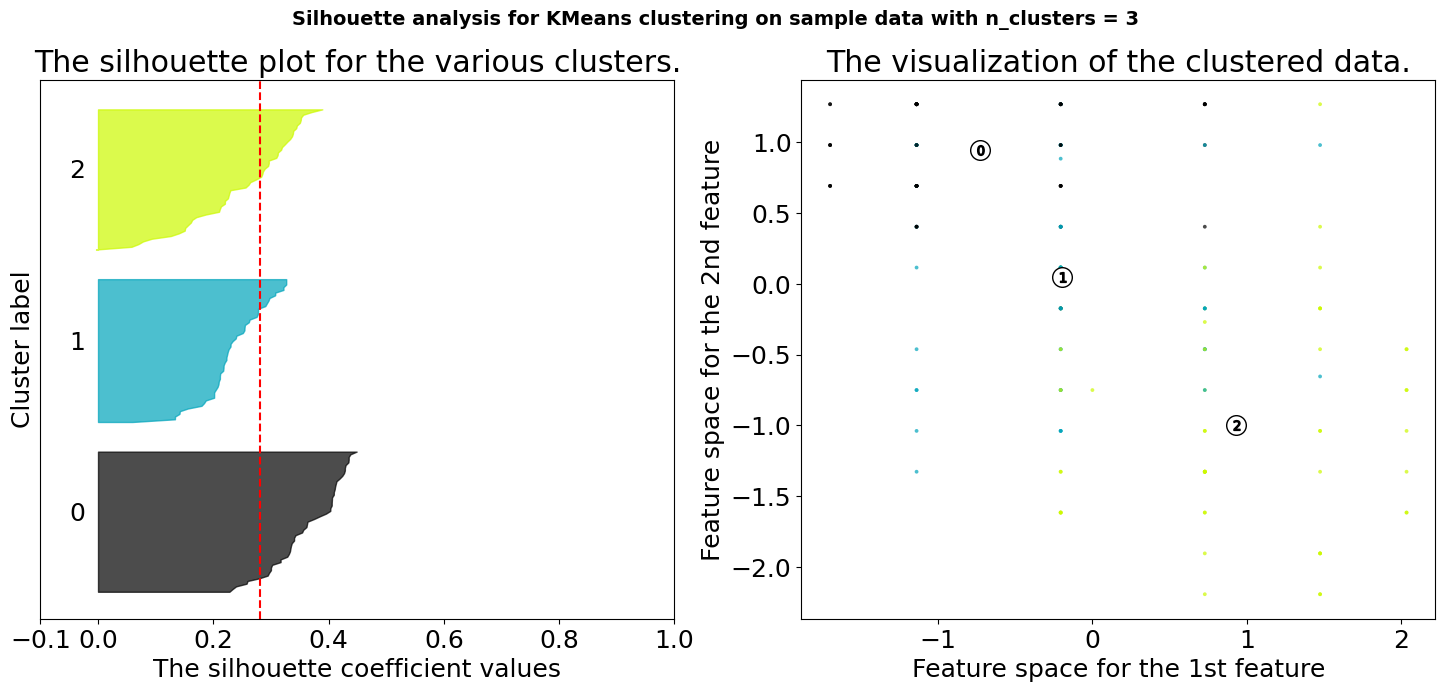

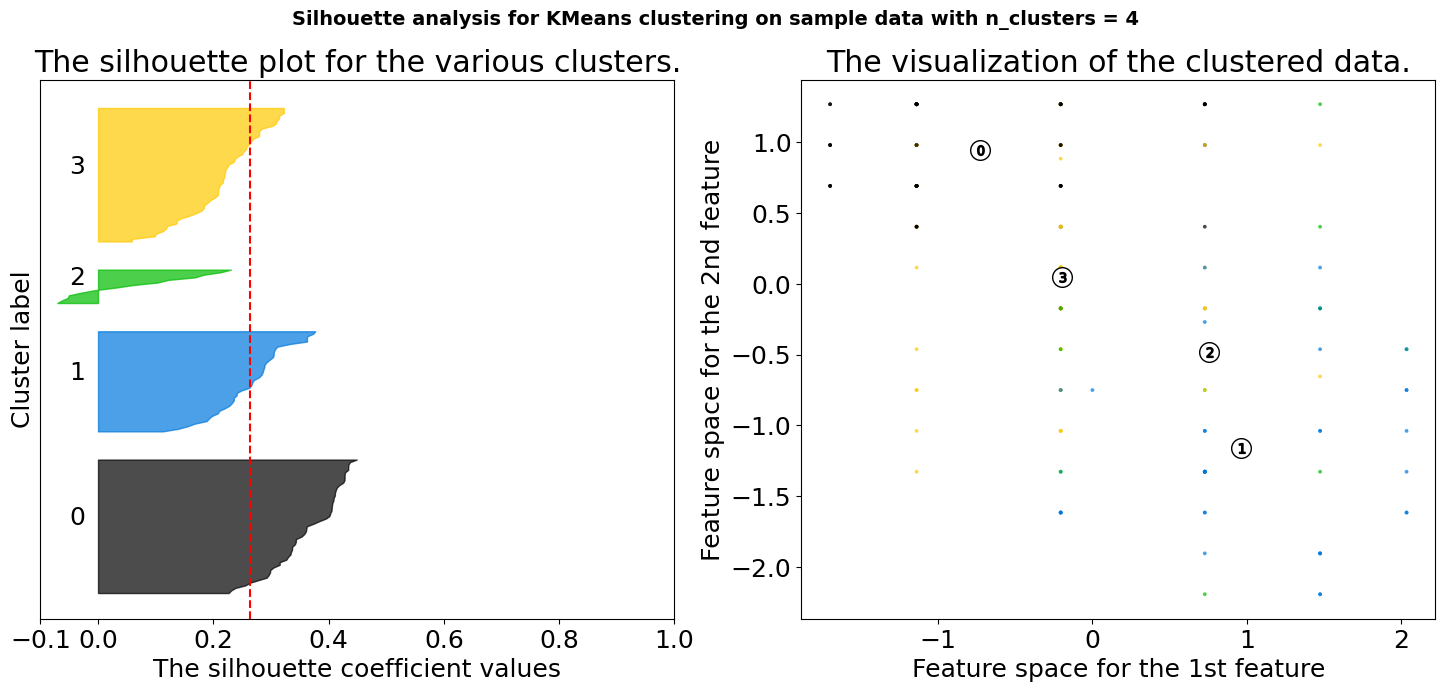

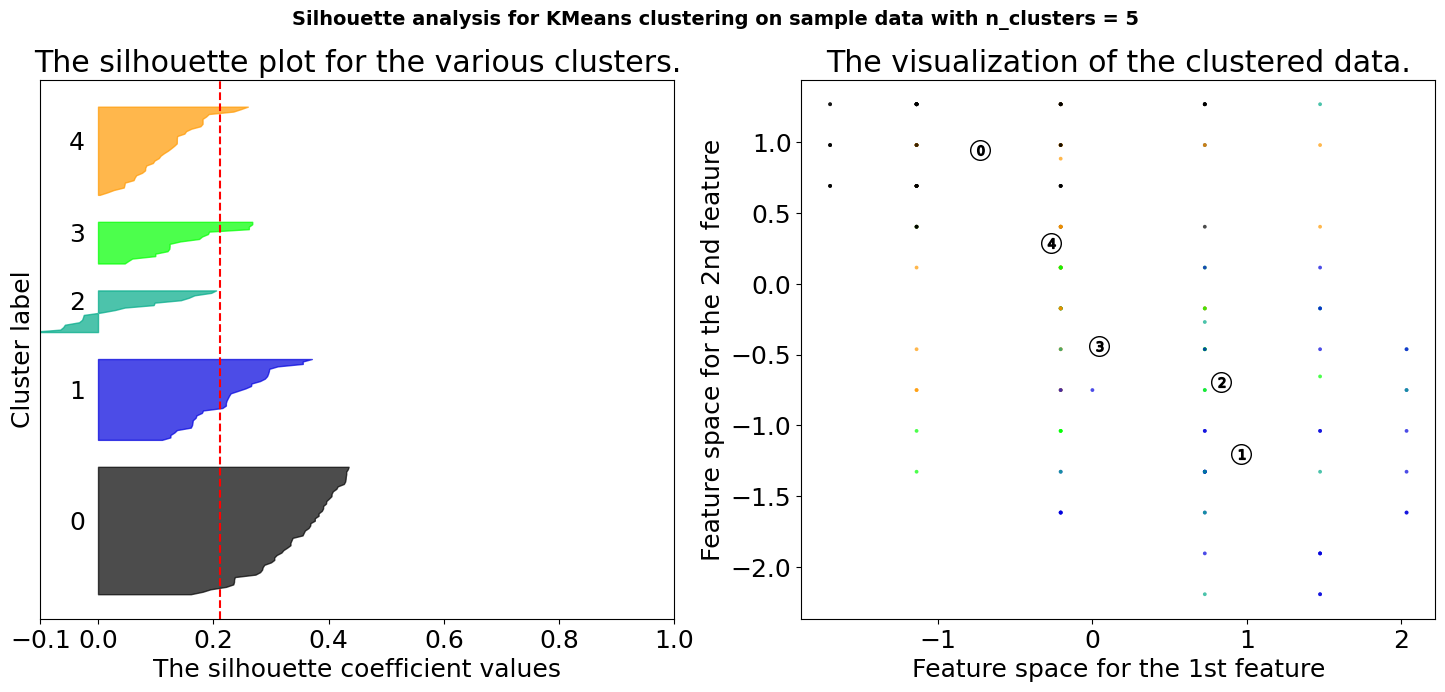

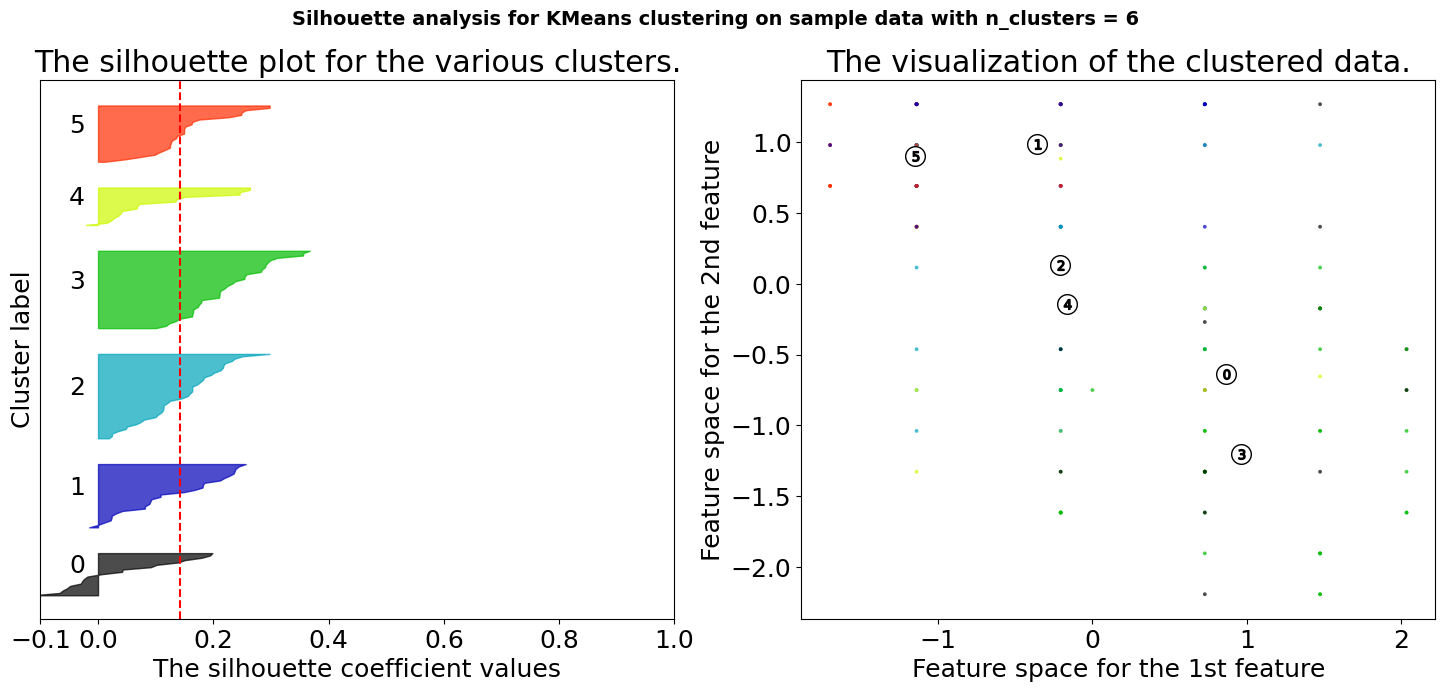

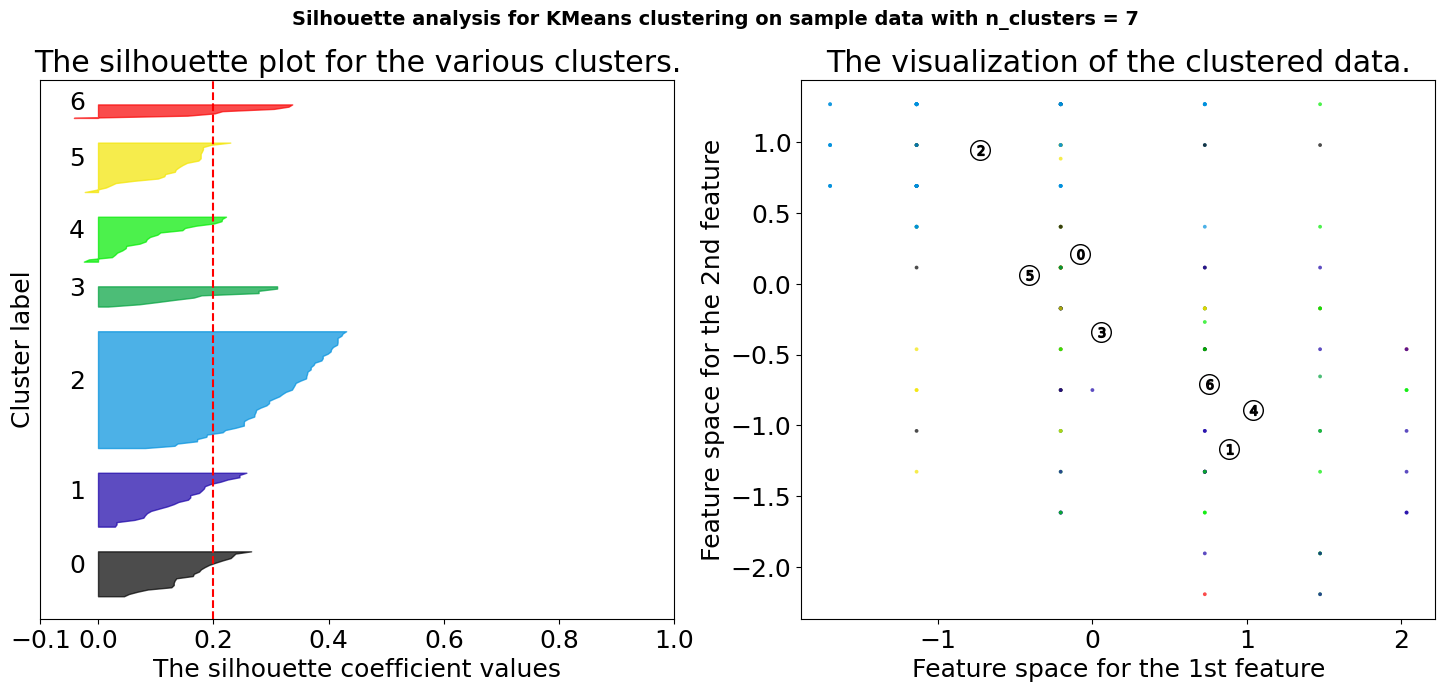

In [21]:
X = X_std

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.

range_n_clusters = [2, 3, 4, 5, 6, 7]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X.iloc[:, 1], X.iloc[:, 2], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 1], centers[:, 2], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[1], c[2], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [22]:
def Silhouette(X, algo):
    max_distance = 0.4
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        if (algo == "kmeans"):
            clusterer = KMeans(n_clusters=n_clusters, random_state=10)
            cluster_labels = clusterer.fit_predict(X)
        if (algo == "hierarchical"):
            agg_clustering = AgglomerativeClustering(n_clusters= None, distance_threshold = max_distance, linkage='single')
            cluster_labels = agg_clustering.fit_predict(X)
            Z = linkage(X, 'single')
            dendrogram(Z, leaf_rotation=90.,  # rotates the x axis labels
                        leaf_font_size=8.,  # font size for the x axis labels 
                      )

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        if (algo == "kmeans"):
            # Labeling the clusters
            centers = clusterer.cluster_centers_
            # Draw white circles at cluster centers
            ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                        c="white", alpha=1, s=200, edgecolor='k')

            for i, c in enumerate(centers):
                ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                            s=50, edgecolor='k')
                        
        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        #ax2.scatter(X.iloc[:, 0], X.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
        #            c=colors, edgecolor='k')

    

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.show()

For n_clusters = 2 The average silhouette_score is : 0.11875
For n_clusters = 3 The average silhouette_score is : 0.11875
For n_clusters = 4 The average silhouette_score is : 0.11875
For n_clusters = 5 The average silhouette_score is : 0.11875
For n_clusters = 6 The average silhouette_score is : 0.11875
For n_clusters = 7 The average silhouette_score is : 0.11875


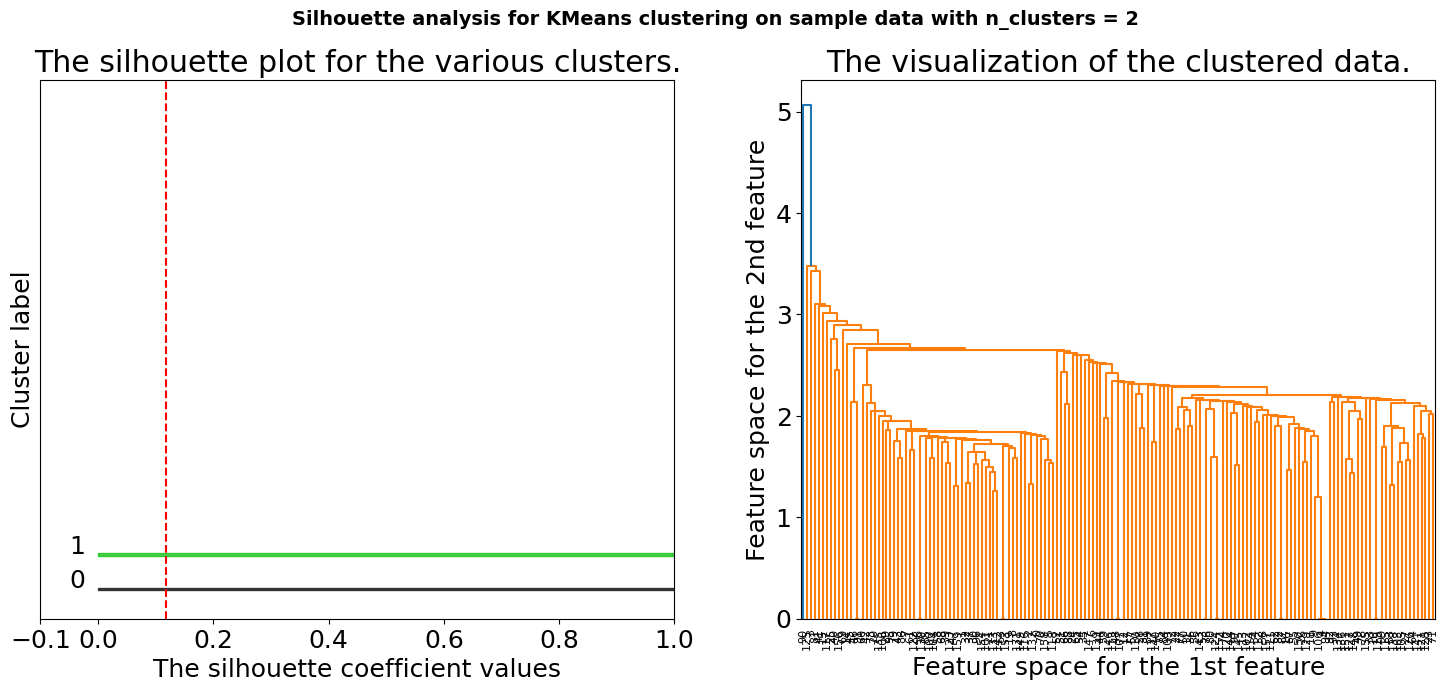

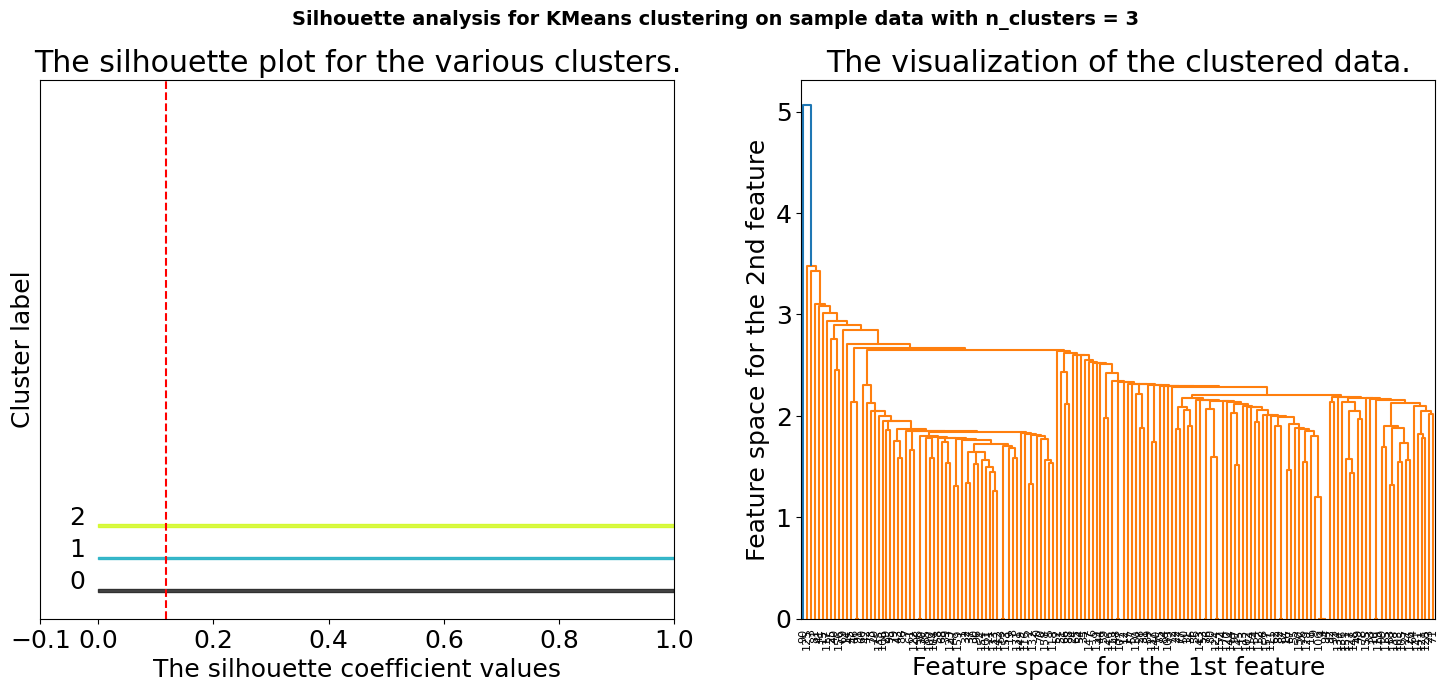

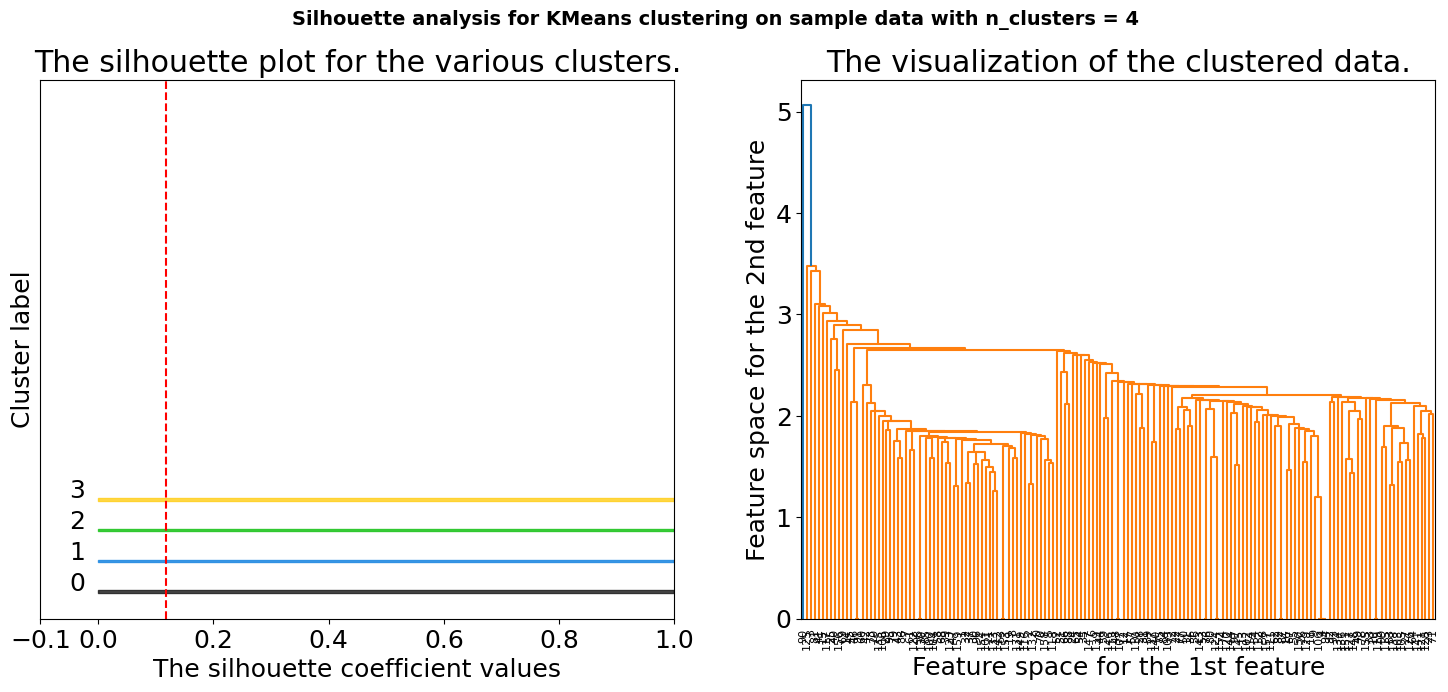

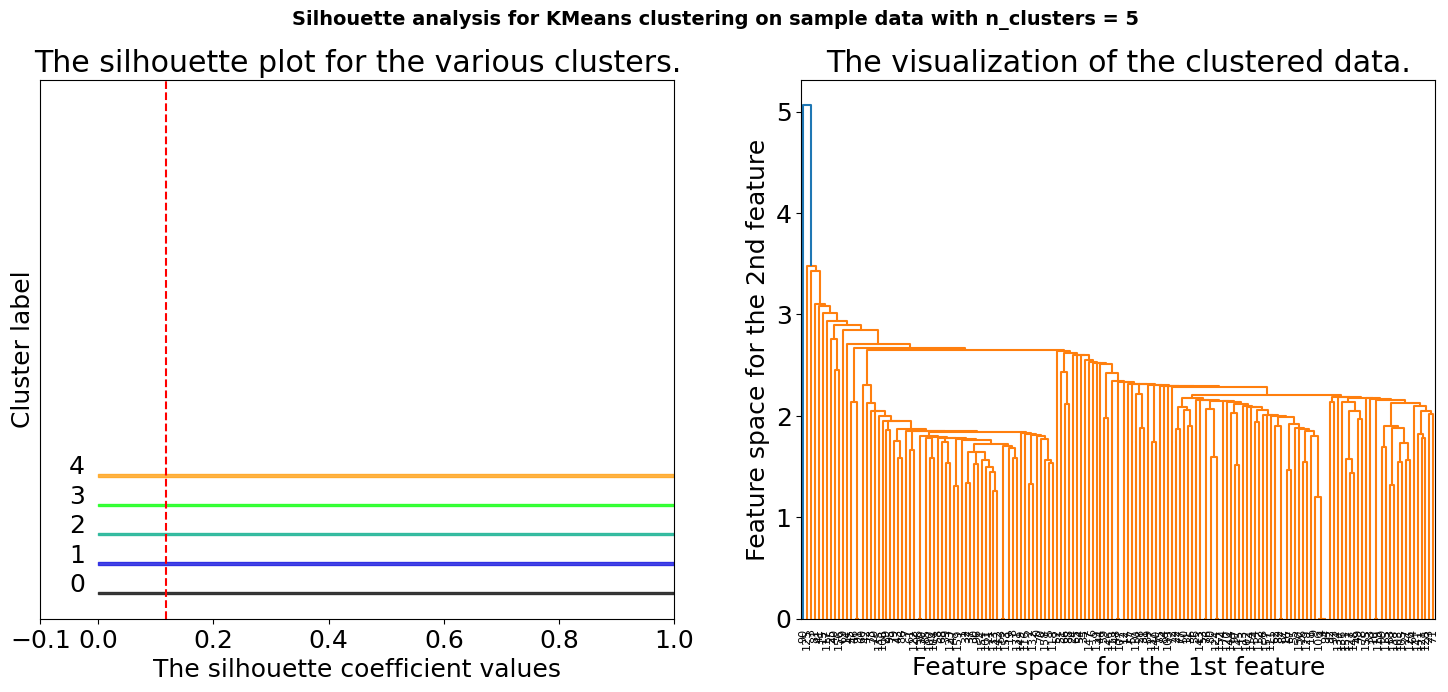

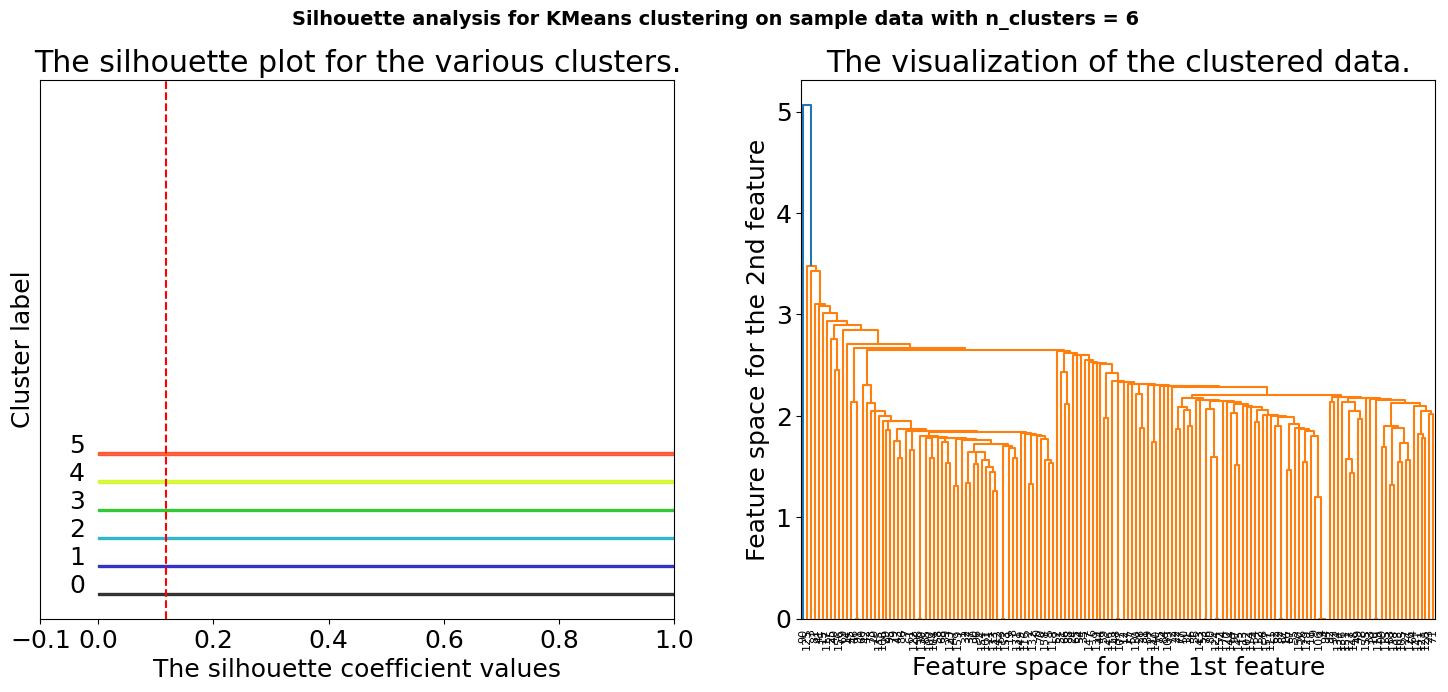

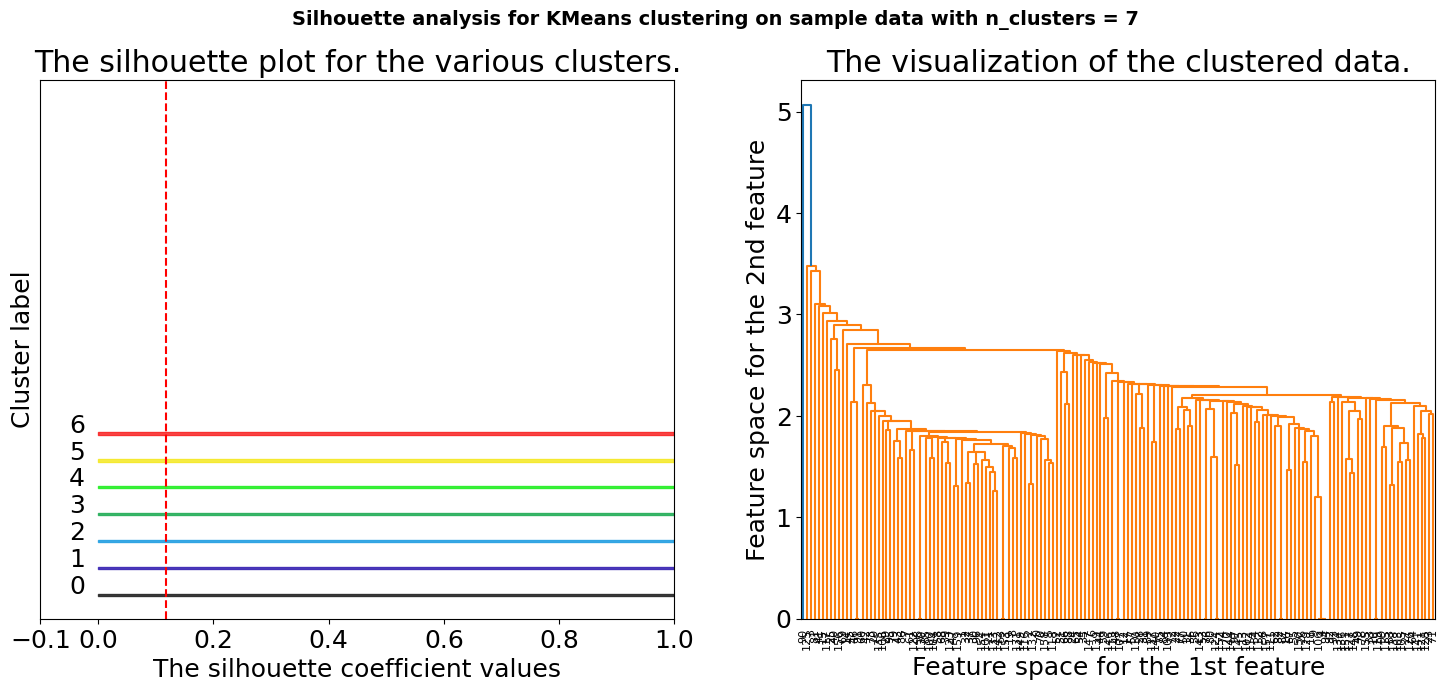

For n_clusters = 2 The average silhouette_score is : 0.1447195323495662
For n_clusters = 3 The average silhouette_score is : 0.1447195323495662
For n_clusters = 4 The average silhouette_score is : 0.1447195323495662
For n_clusters = 5 The average silhouette_score is : 0.1447195323495662
For n_clusters = 6 The average silhouette_score is : 0.1447195323495662
For n_clusters = 7 The average silhouette_score is : 0.1447195323495662


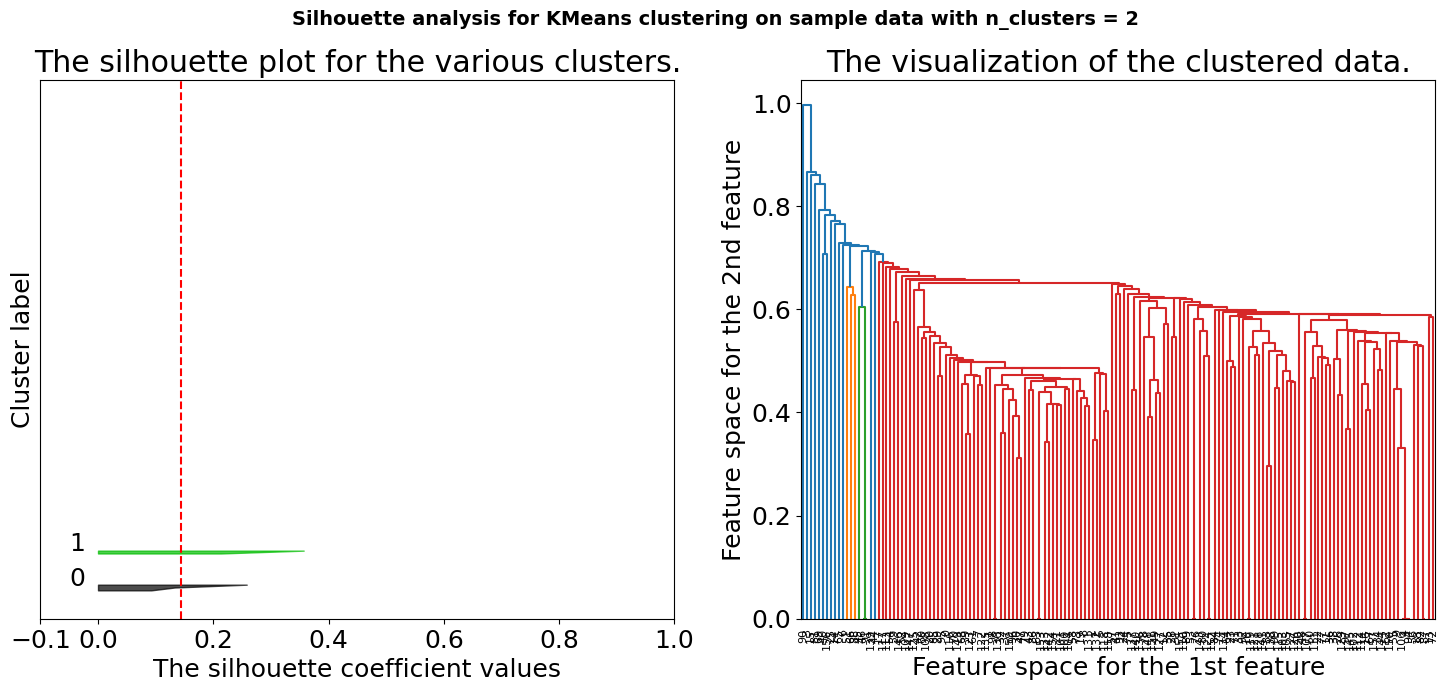

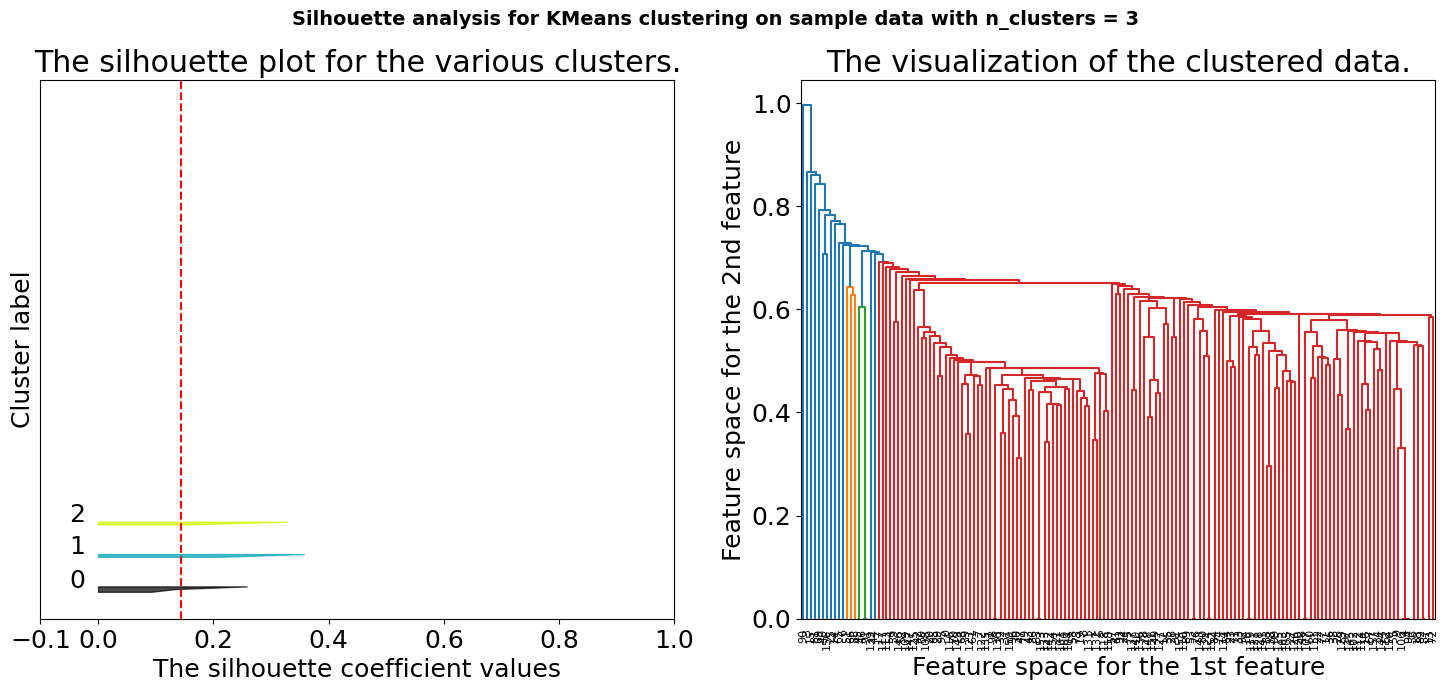

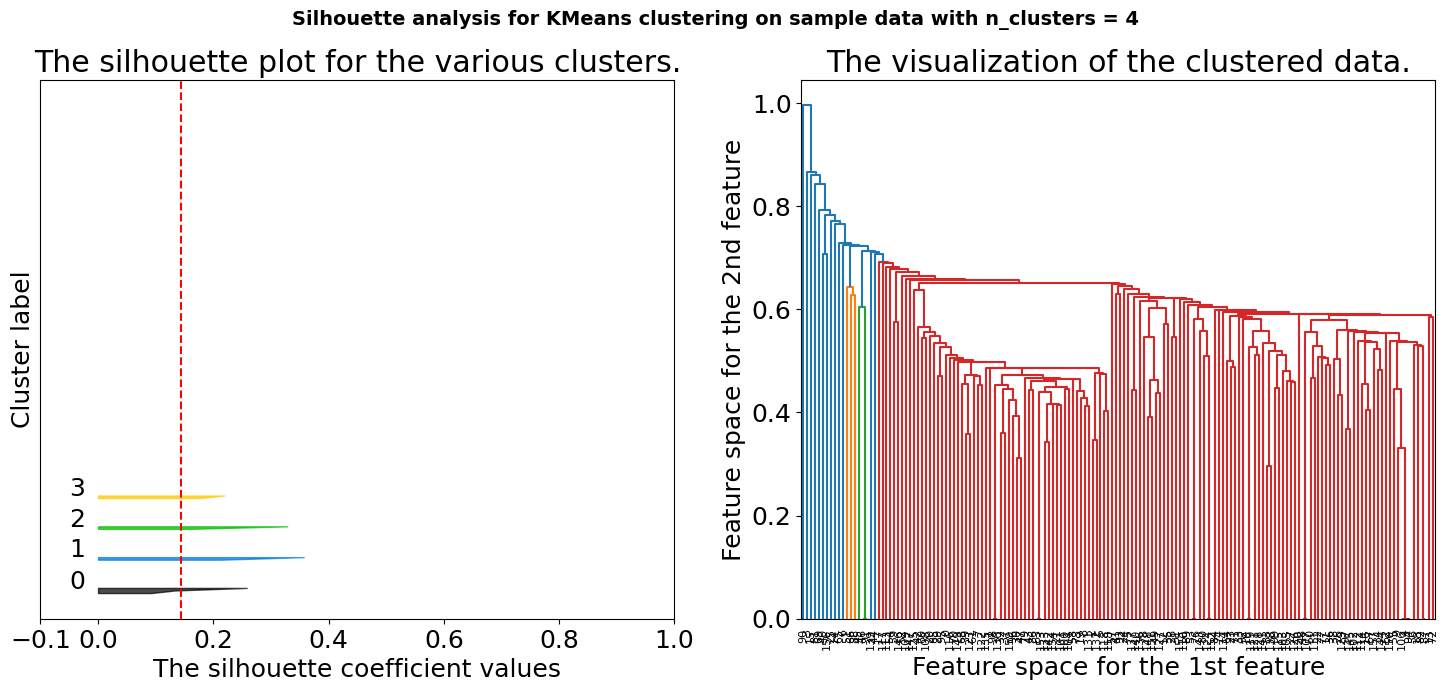

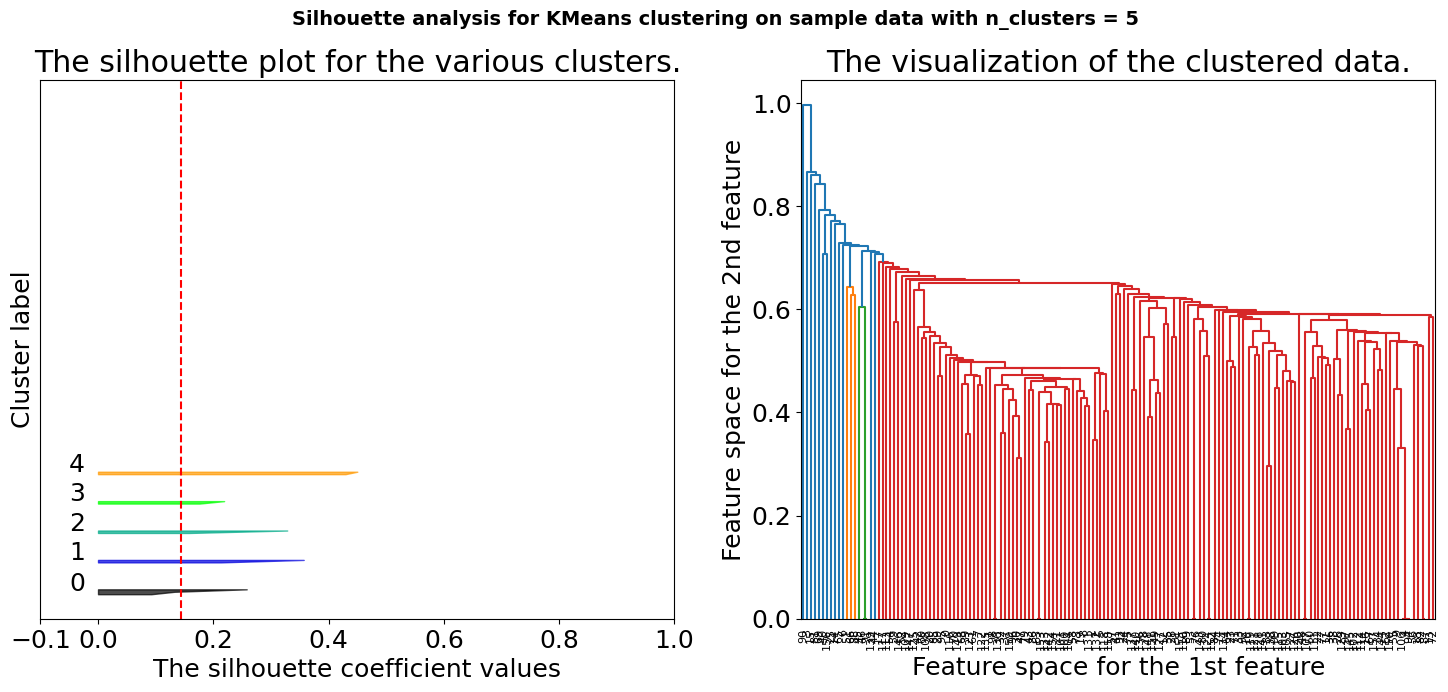

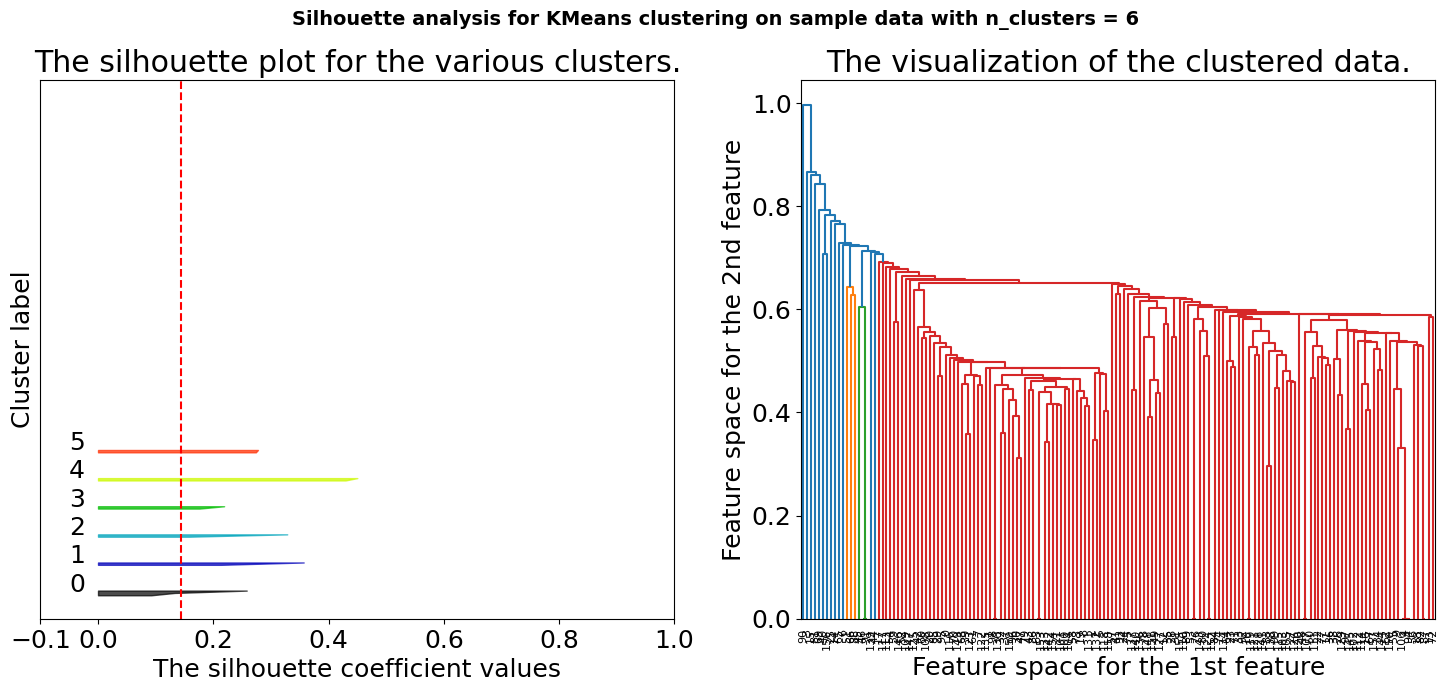

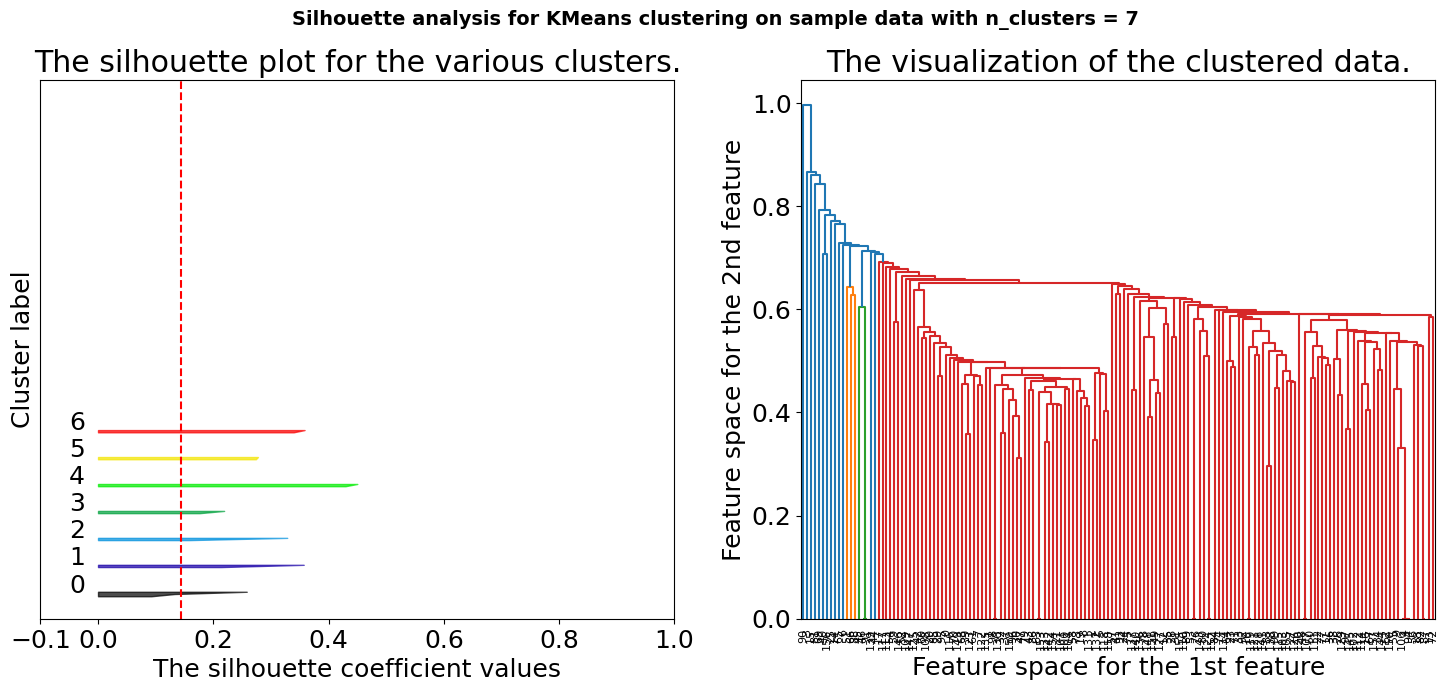

In [23]:
# clusterer = KMeans(n_clusters=n_clusters, random_state=10)
# Silhouette(X_std, "kmeans")
# Silhouette(X_nrm, "kmeans")
Silhouette(X_std, "hierarchical")
Silhouette(X_nrm, "hierarchical")

In [24]:
def Silhouette(X, algo):
    max_distance = 0.4
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        if (algo == "kmeans"):
            clusterer = KMeans(n_clusters=n_clusters, random_state=10)
            cluster_labels = clusterer.fit_predict(X)
            # Labeling the clusters
            centers = clusterer.cluster_centers_
            # Draw white circles at cluster centers
            ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                        c="white", alpha=1, s=200, edgecolor='k')

            for i, c in enumerate(centers):
                ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                            s=50, edgecolor='k')
        if (algo == "hierarchical"):
            Z = linkage(X, 'single')
            dendrogram(Z, orientation='top')
            cluster_labels = fcluster(Z, max_distance, criterion='distance')

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
       # ax2.scatter(X.iloc[:, 0], X.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    #c=colors, edgecolor='k')

    

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.show()

For n_clusters = 2 The average silhouette_score is : 0.11875
For n_clusters = 3 The average silhouette_score is : 0.11875
For n_clusters = 4 The average silhouette_score is : 0.11875
For n_clusters = 5 The average silhouette_score is : 0.11875
For n_clusters = 6 The average silhouette_score is : 0.11875
For n_clusters = 7 The average silhouette_score is : 0.11875


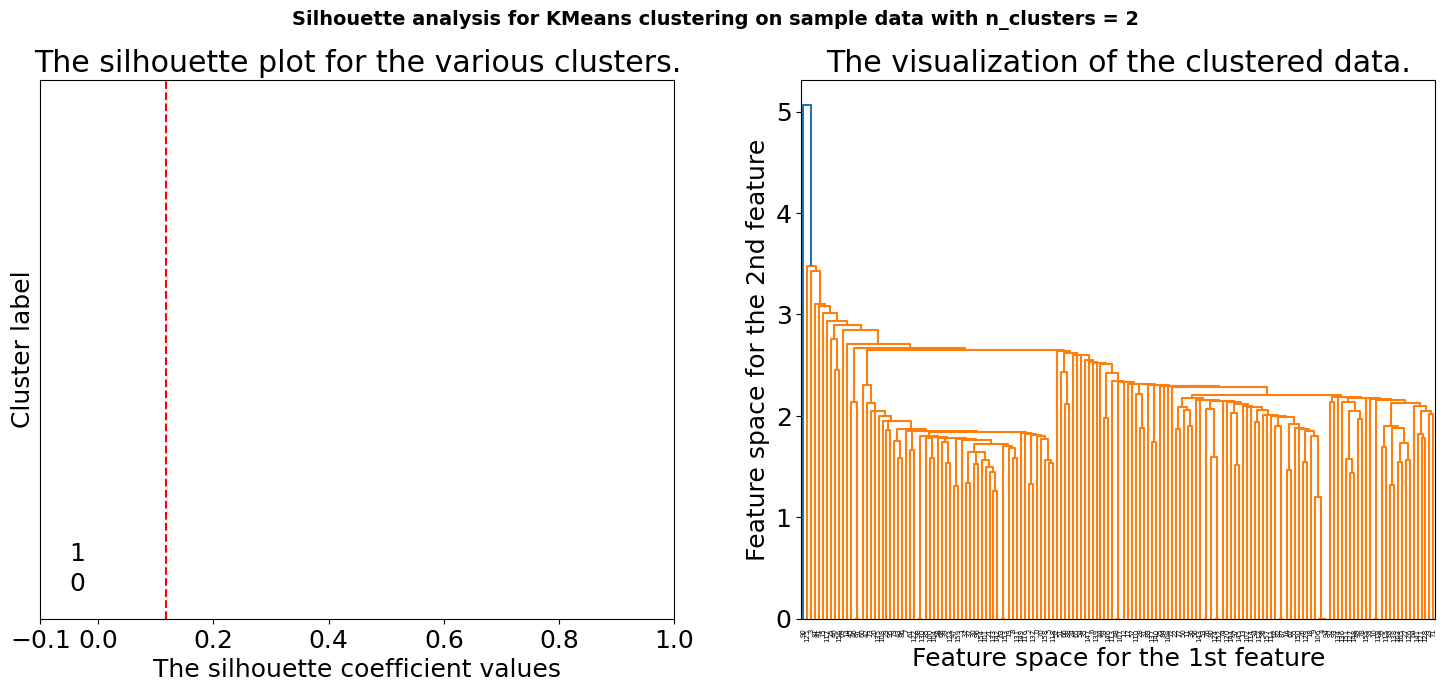

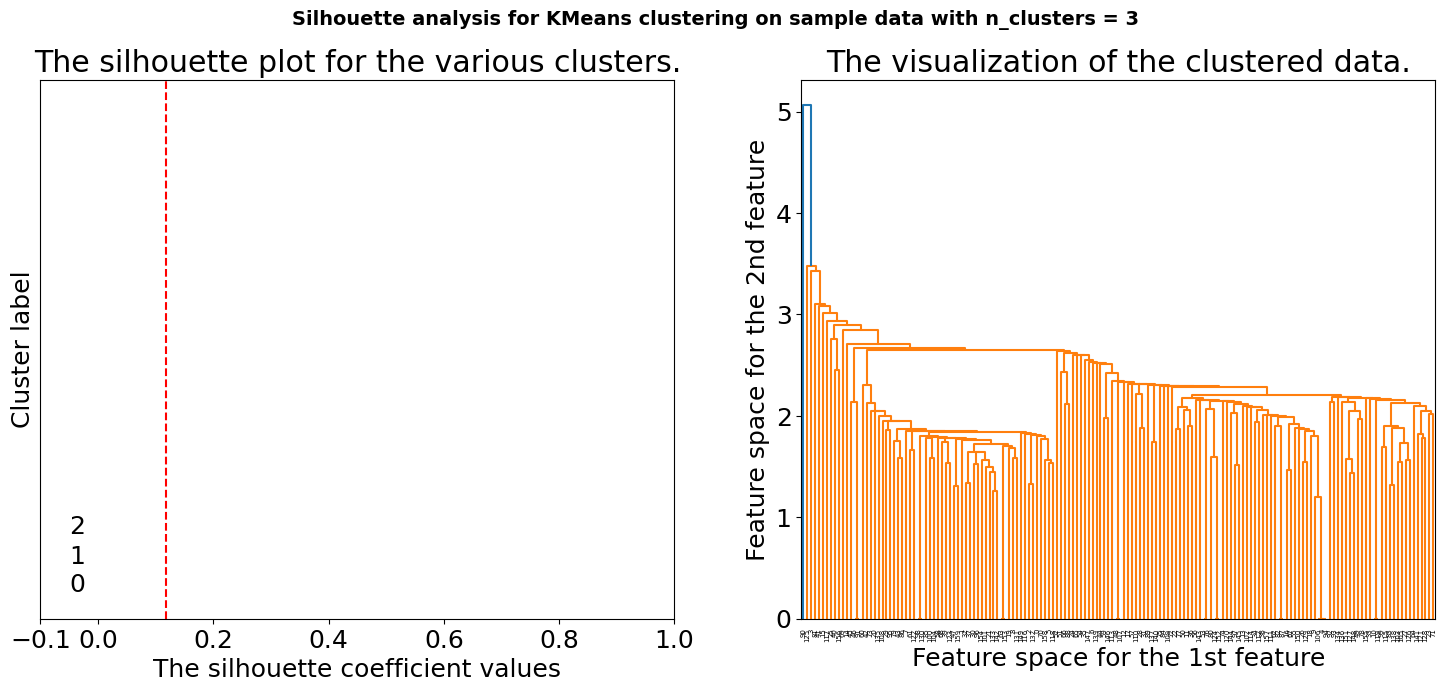

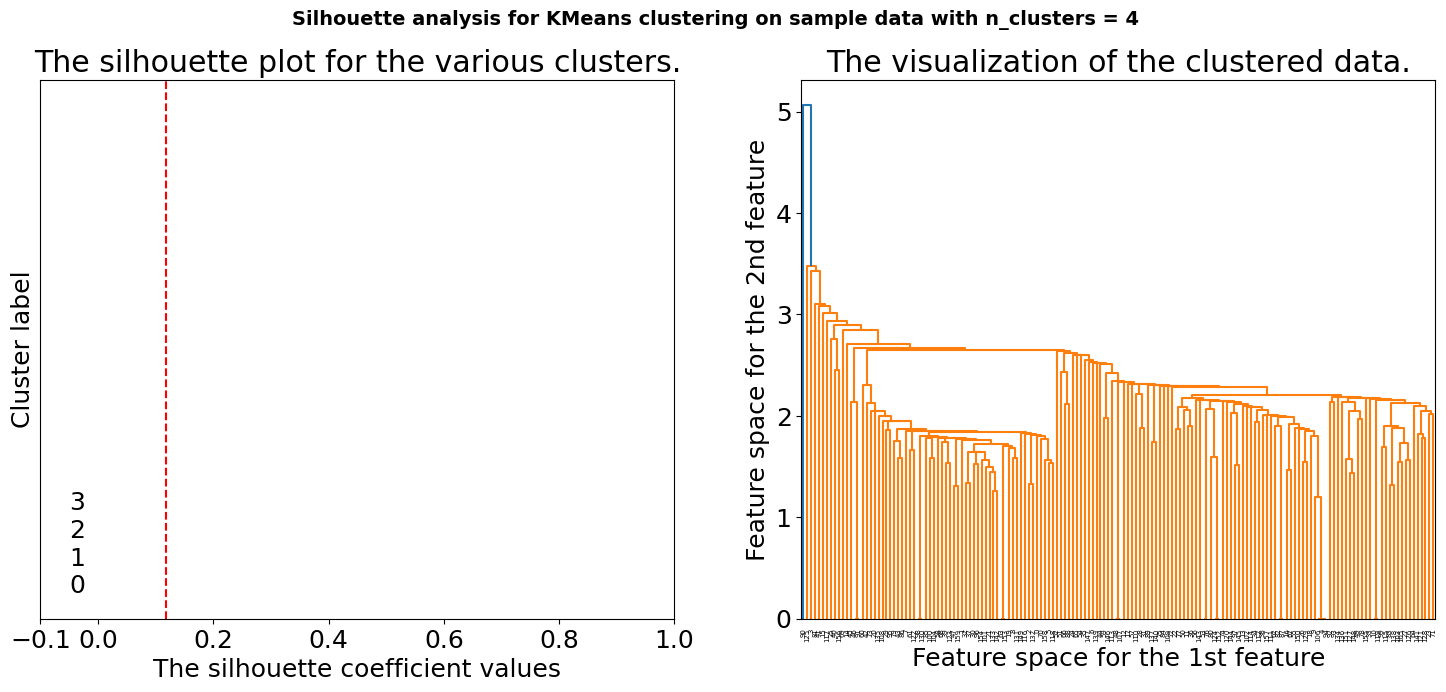

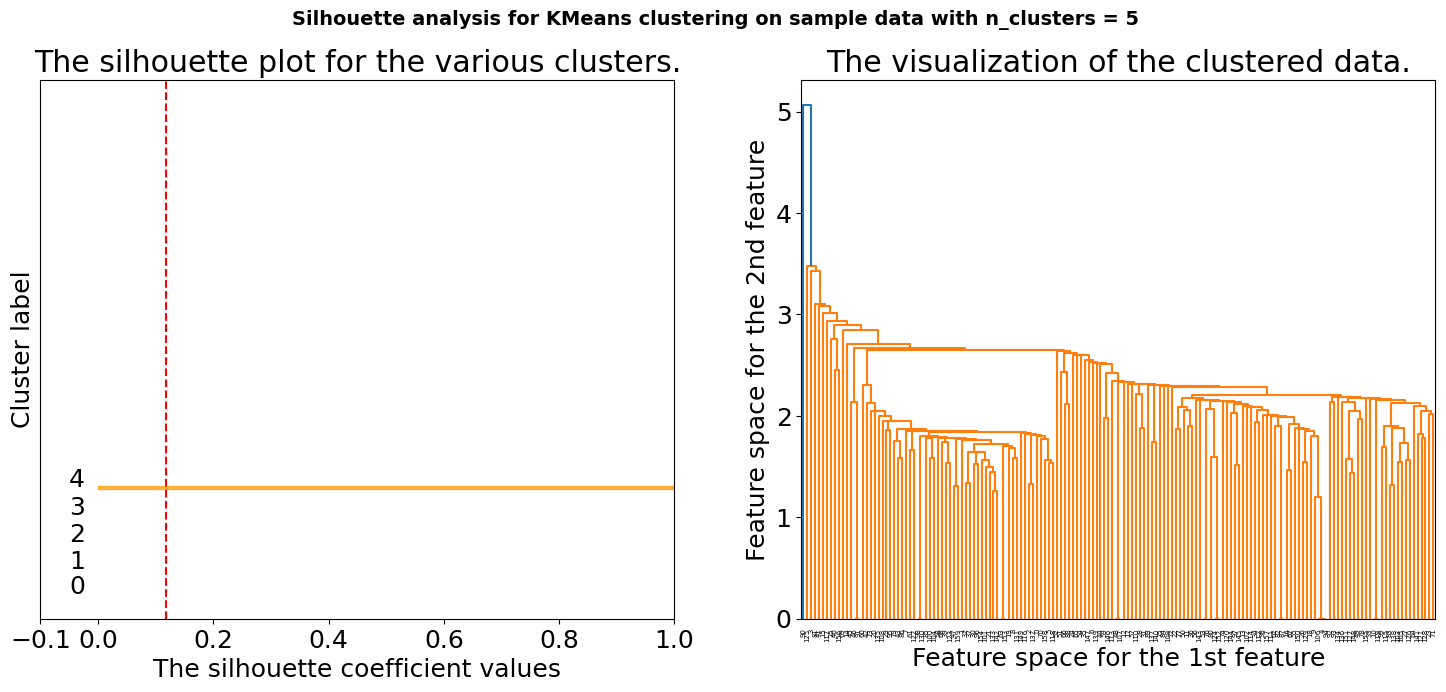

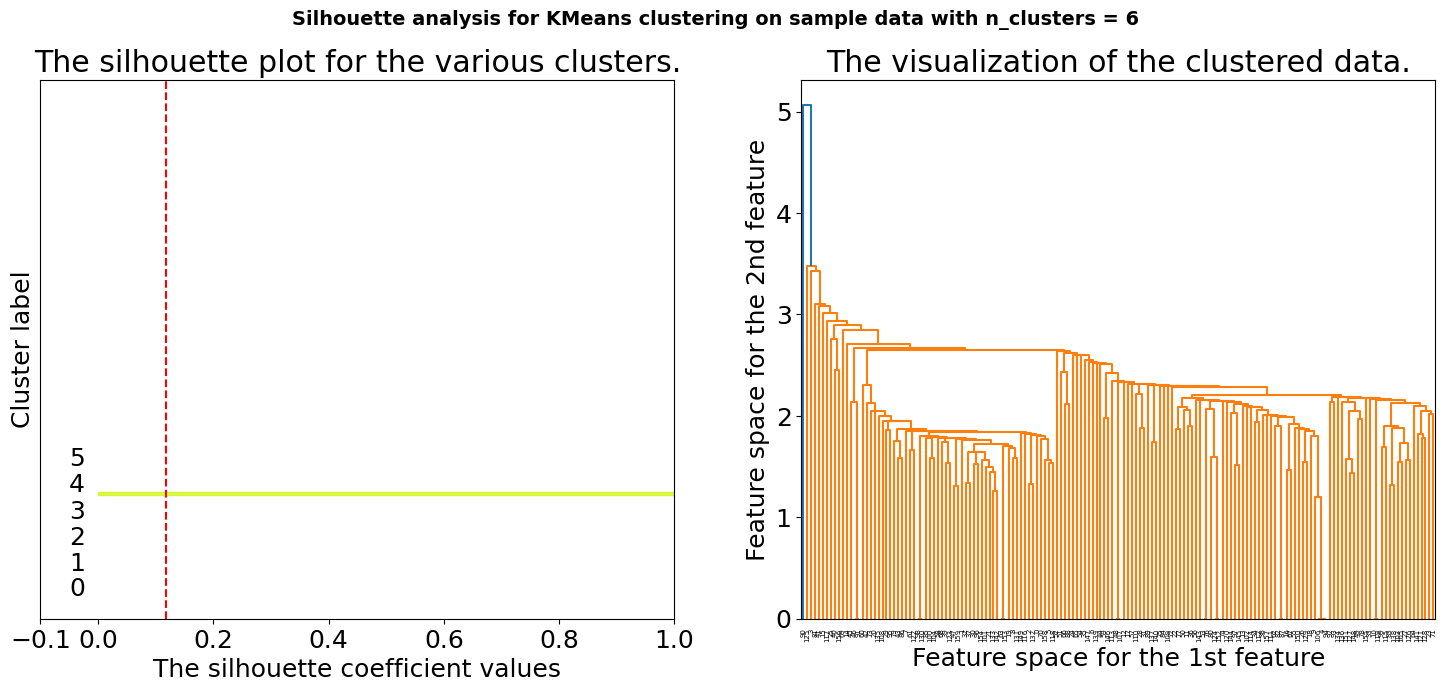

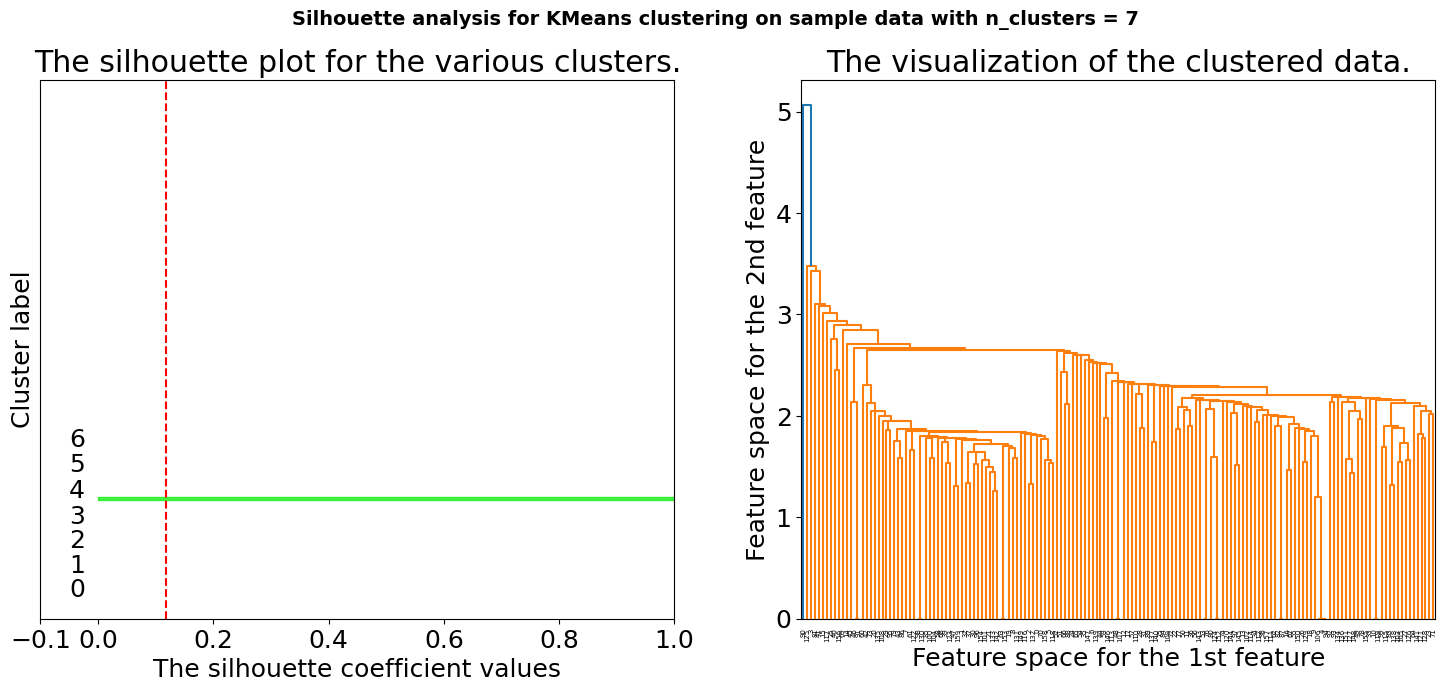

For n_clusters = 2 The average silhouette_score is : 0.1447195323495662
For n_clusters = 3 The average silhouette_score is : 0.1447195323495662
For n_clusters = 4 The average silhouette_score is : 0.1447195323495662
For n_clusters = 5 The average silhouette_score is : 0.1447195323495662
For n_clusters = 6 The average silhouette_score is : 0.1447195323495662
For n_clusters = 7 The average silhouette_score is : 0.1447195323495662


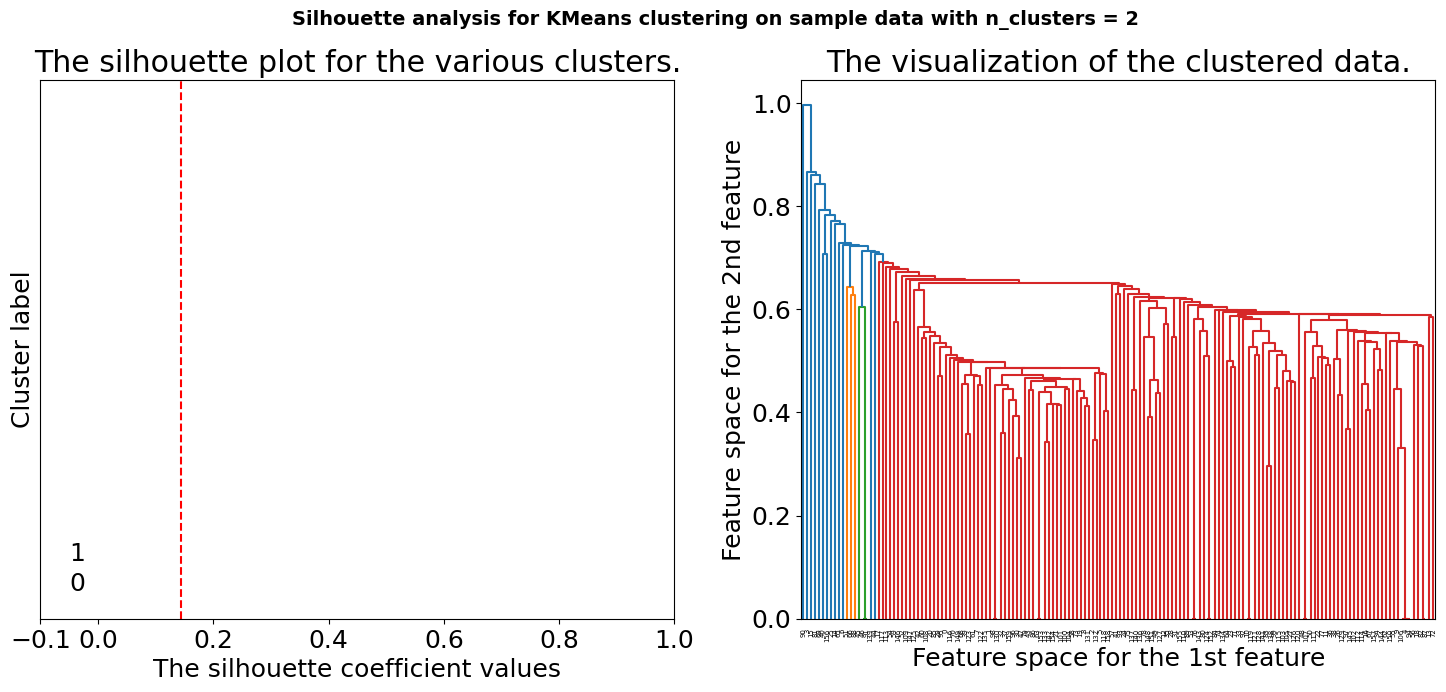

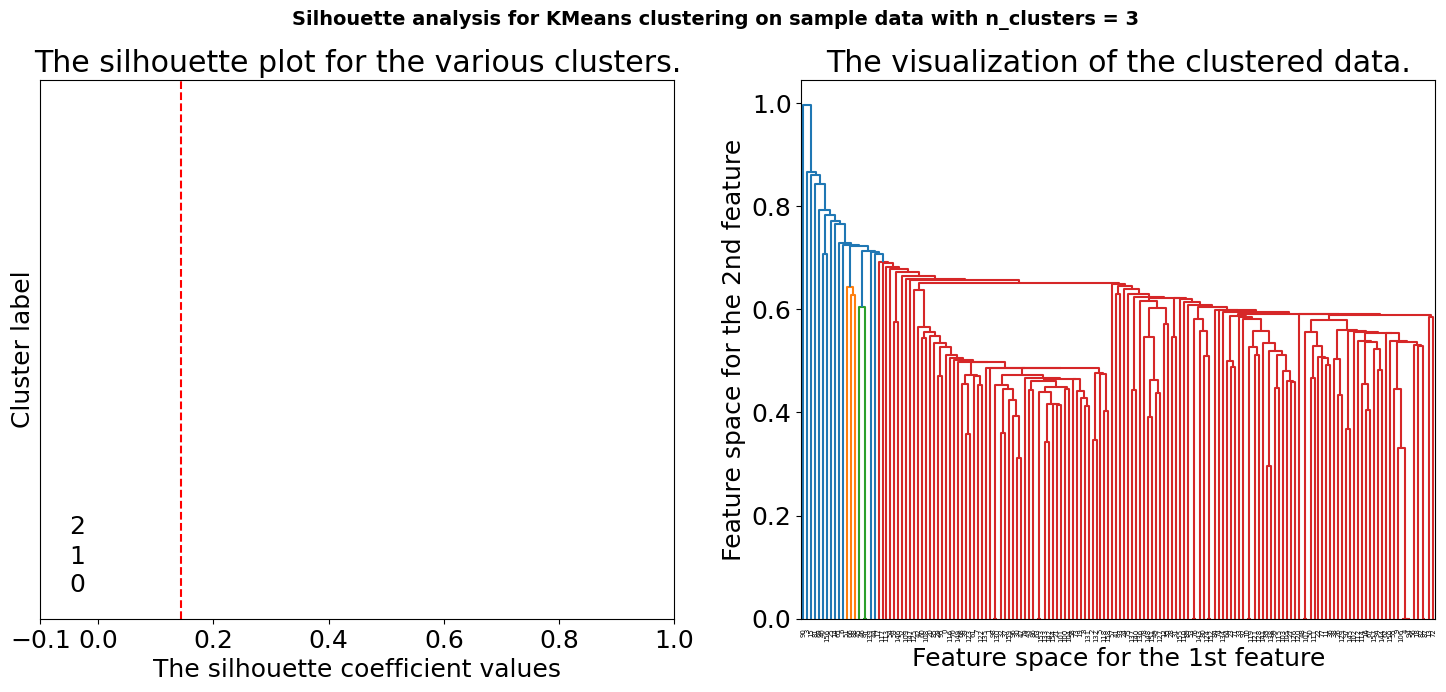

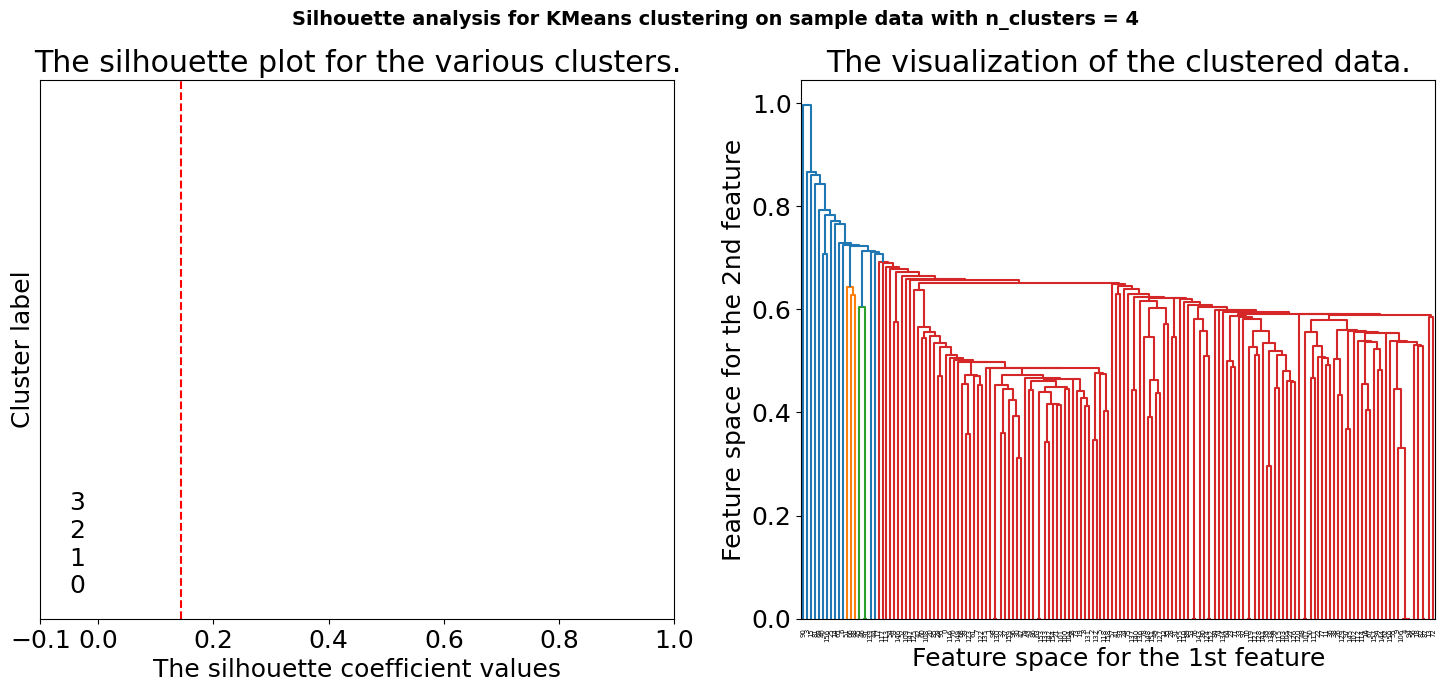

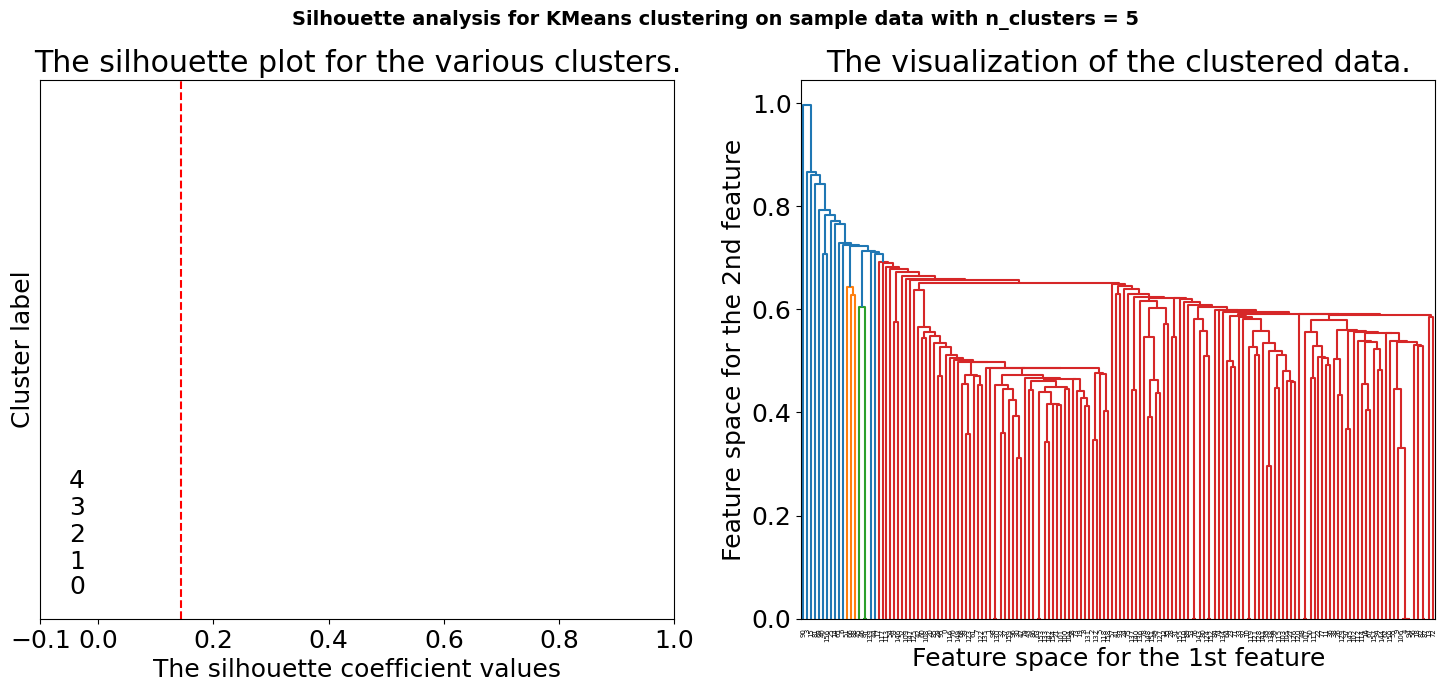

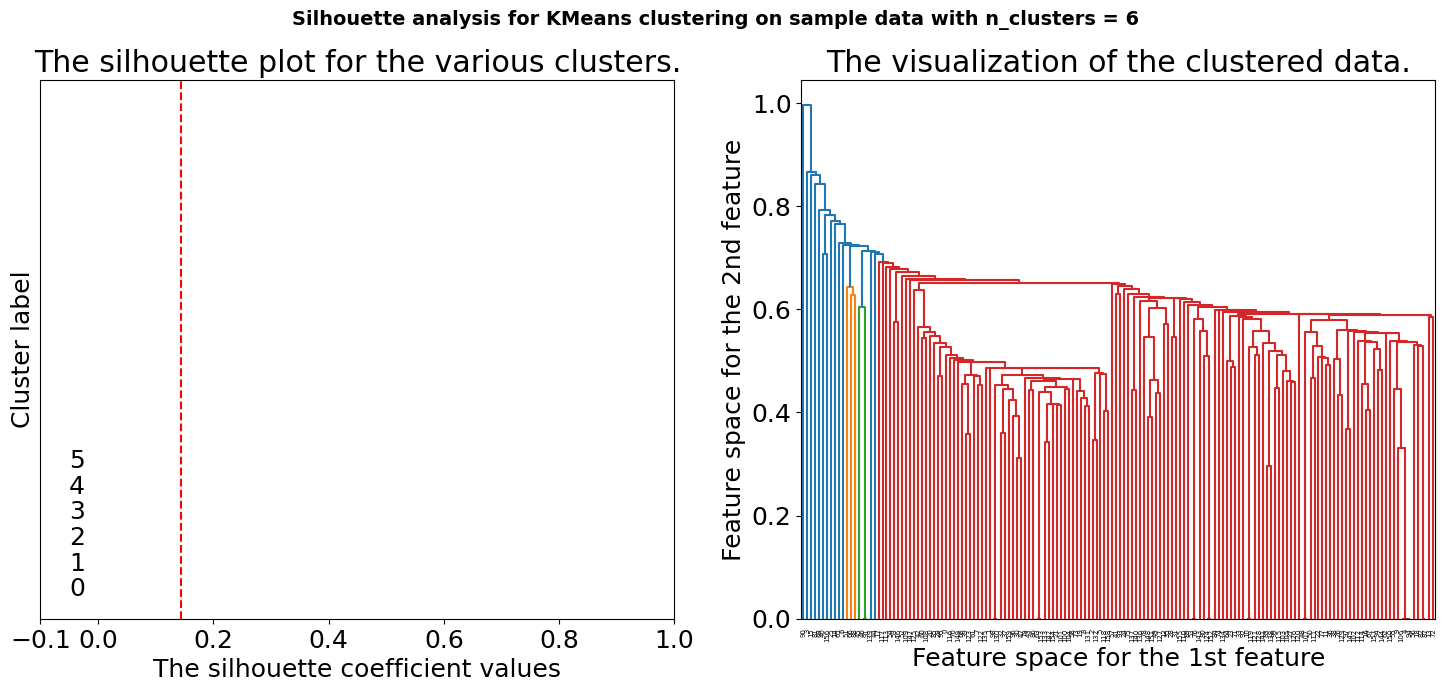

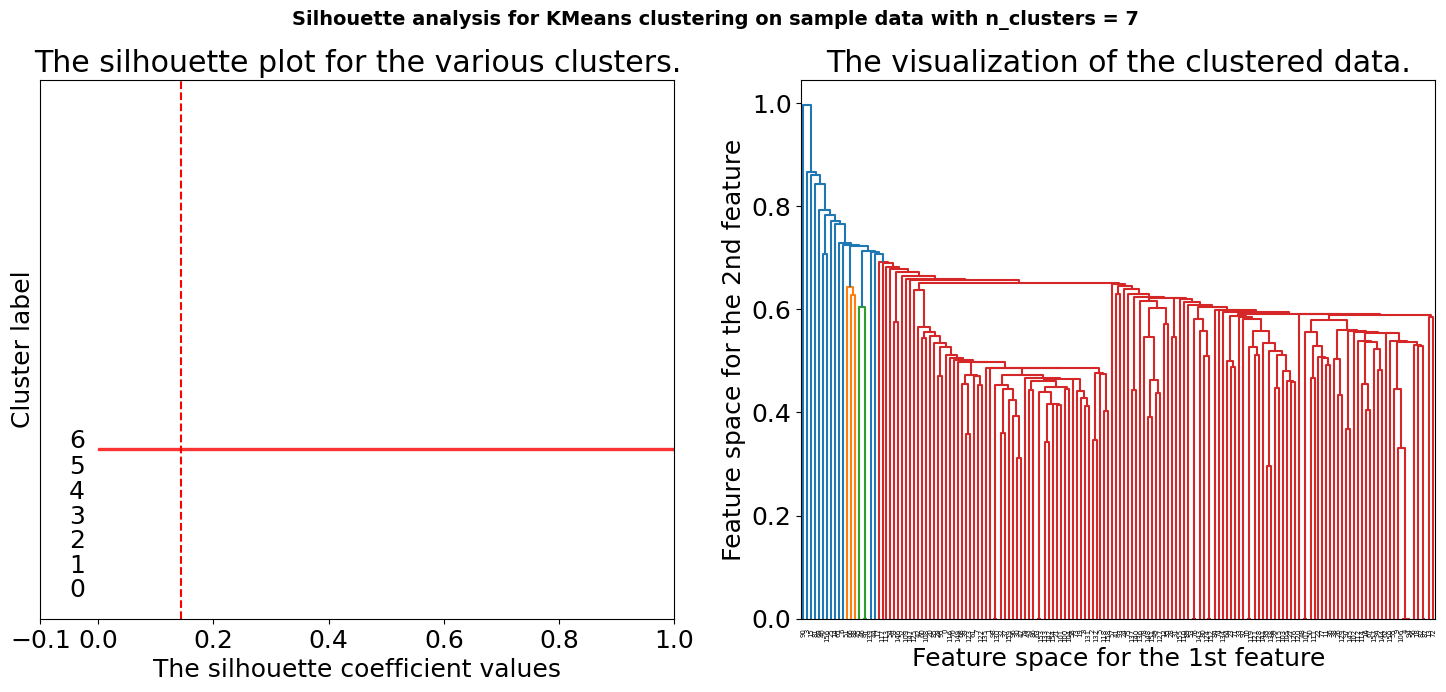

In [25]:
# clusterer = KMeans(n_clusters=n_clusters, random_state=10)
# Silhouette(X_std, "kmeans")
# Silhouette(X_nrm, "kmeans")
Silhouette(X_std, "hierarchical")
Silhouette(X_nrm, "hierarchical")

### New Silhouette agglomerative

In [26]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np

In [27]:
range_clusters = [i for i in range(2, 20)]
def Silhouette_Agglomerative(X):
    # Specify the number of clusters
    for n_clusters in range_clusters:

        # Create an AgglomerativeClustering model
        model = AgglomerativeClustering(n_clusters=n_clusters)
        # Fit the model to the data
        model.fit(X)
        # Get cluster labels for each data point
        labels = model.labels_

        # Calculate the silhouette score
        silhouette_avg = silhouette_score(X, labels)

        print(f"Silhouette Score for {n_clusters} : {silhouette_avg}")

In [28]:
Silhouette_Agglomerative(X_std)

Silhouette Score for 2 : 0.32814067833781674
Silhouette Score for 3 : 0.28103628509892653
Silhouette Score for 4 : 0.27314033551832057
Silhouette Score for 5 : 0.22837452640863823
Silhouette Score for 6 : 0.22441971102117755
Silhouette Score for 7 : 0.16044601606626174
Silhouette Score for 8 : 0.12509934391477584
Silhouette Score for 9 : 0.1254182646033976
Silhouette Score for 10 : 0.12536154575398897
Silhouette Score for 11 : 0.1307356716249075
Silhouette Score for 12 : 0.12955017441079758
Silhouette Score for 13 : 0.1366741520385945
Silhouette Score for 14 : 0.13676529405540777
Silhouette Score for 15 : 0.13641479288062444
Silhouette Score for 16 : 0.13988442531642029
Silhouette Score for 17 : 0.1388222783144327
Silhouette Score for 18 : 0.13760280293505417
Silhouette Score for 19 : 0.1399012439569603


In [29]:
Silhouette_Agglomerative(X_nrm)

Silhouette Score for 2 : 0.3149999810842976
Silhouette Score for 3 : 0.275572319720495
Silhouette Score for 4 : 0.24307126803574403
Silhouette Score for 5 : 0.2316268334766245
Silhouette Score for 6 : 0.19237770645838254
Silhouette Score for 7 : 0.19437307287156677
Silhouette Score for 8 : 0.1961195428297684
Silhouette Score for 9 : 0.18341273511312428
Silhouette Score for 10 : 0.1774761859271214
Silhouette Score for 11 : 0.1629637401675064
Silhouette Score for 12 : 0.17170842267712863
Silhouette Score for 13 : 0.17609413567176513
Silhouette Score for 14 : 0.1707787240927625
Silhouette Score for 15 : 0.1567951378028095
Silhouette Score for 16 : 0.15757036873267655
Silhouette Score for 17 : 0.14972992272803232
Silhouette Score for 18 : 0.15154644207222218
Silhouette Score for 19 : 0.1514729843304195
